# 노드내용 복습

## 내가 원하는 숫자 만들기

### 0. 패키지 로딩하기

In [1]:
from tensorflow.keras import optimizers, losses
from tensorflow.keras import layers, Input, Model

import os
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

### 1. 데이터 준비하기

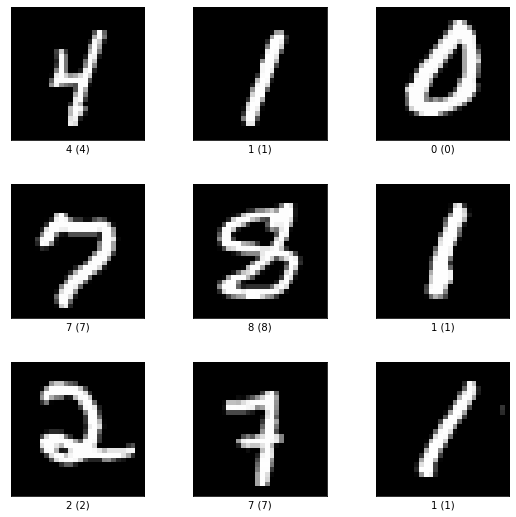

In [2]:
mnist, info = tfds.load("mnist", split = "train", with_info = True)

fig = tfds.show_examples(mnist, info)

* 여러 개의 숫자 이미지와 그에 알맞은 레이블이 출력되었다.
* 학습 전에 필요한 몇 가지 처리를 수행하는 함수를 정의한다.
* 이미지 픽셀값을 -1~1 사이의 범위로 변경하고, 레이블 정보를 원-핫 인코딩(one-hot encoding)했다.
* GAN과 cGAN 각각을 실험해 보기 위해 label 정보 사용 유무에 따라 gan_preprocessing()과 cgan_preprocessing() 두 가지 함수를 구성해 놓았다.

In [3]:
BATCH_SIZE = 128

def gan_preprocessing(data):
    image = data["image"]
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1
    return image

def cgan_preprocessing(data):
    image = data["image"]
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1
    
    label = tf.one_hot(data["label"], 10)
    return image, label

gan_datasets  = mnist.map(gan_preprocessing).shuffle(1000).batch(BATCH_SIZE)
cgan_datasets = mnist.map(cgan_preprocessing).shuffle(100).batch(BATCH_SIZE)

* 원하는 대로 정확히 처리되었는지 한 개 데이터셋만 선택해 확인해본다.
* 이미지에 쓰인 숫자와 레이블이 일치해야 하고, 이미지 값의 범위가 -1~1 사이에 있어야 한다.

Label : tf.Tensor([0. 0. 0. 1. 0. 0. 0. 0. 0. 0.], shape=(10,), dtype=float32)
Image Min / Max : -1.0 1.0


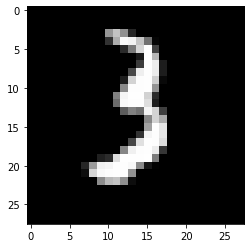

In [4]:
for i, j in cgan_datasets: break
    
# 이미지 i와 라벨 j가 일치하는지 확인해 본다.
print("Label :", j[0])
print("Image Min / Max :", i.numpy().min(), i.numpy().max())
plt.imshow(i.numpy()[0, ..., 0], plt.cm.gray)

# 원-핫 인코딩으로 표현된 Label과 출력된 이미지가 일치하는지 확인해야하므로, 보는 법을 알아보자.
# 0과 1로 이루어진 원-핫 벡터에는 각자 고유의 인덱스가 있습니다.
# MNIST의 경우, 숫자 0은 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.], 숫자 6은 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]의 값을 가진다.
# 이제 위 코드의 output을 확인해 이미지 i와 라벨 j가 일치하는지 확인해본다.

### 2. GAN Generator 구성하기

* 이번 구현은 Tensorflow2의 Subclassing 방법을 이용한다.
* Subclassing 방법은 tensorflow.keras.Model 을 상속받아 클래스를 만들며, 일반적으로 __init__() 메서드 안에서 레이어 구성을 정의하고, 구성된 레이어를 call() 메서드에서 사용해 forward propagation을 진행한다.
* 이러한 Subclassing 방법은 Pytorch의 모델 구성 방법과도 매우 유사하므로 이에 익숙해진다면 Pytorch의 모델 구성 방법도 빠르게 습득할 수 있다고 한다.

In [5]:
# 먼저 GAN의 Generator를 아래와 같이 구현했다.
class GeneratorGAN(Model):
    def __init__(self):
        super(GeneratorGAN, self).__init__()
        
        self.dense_1 = layers.Dense(128,         activation = "relu")
        self.dense_2 = layers.Dense(256,         activation = "relu")
        self.dense_3 = layers.Dense(512,         activation = "relu")
        self.dense_4 = layers.Dense(28 * 28 * 1, activation = "tanh")
        
        self.reshape = layers.Reshape((28, 28, 1))
        
    def call(self, noise):
        out = self.dense_1(noise)
        out = self.dense_2(out)
        out = self.dense_3(out)
        out = self.dense_4(out)
        return self.reshape(out)

* __init__() 메서드 안에서 사용할 모든 레이어를 정의했다.
* 4개의 fully-connected 레이어 중 한 개를 제외하고 모두 ReLU 활성화를 사용하는 것을 확인할 수 있다.
* call() 메서드에서는 노이즈를 입력받아 __init__()에서 정의된 레이어들을 순서대로 통과한다.
* Generator는 숫자가 쓰인 이미지를 출력해야 하므로 마지막 출력은 layers.Reshape()을 이용해 (28,28,1) 크기로 변환된다.

### 3. cGAN Generator 구성하기

In [6]:
class GeneratorCGAN(Model):
    def __init__(self):
        super(GeneratorCGAN, self).__init__()
        
        self.dense_z        = layers.Dense(256,         activation = "relu")
        self.dense_y        = layers.Dense(256,         activation = "relu")
        self.combined_dense = layers.Dense(512,         activation = "relu")
        self.final_dense    = layers.Dense(28 * 28 * 1, activation = "tanh")
        self.reshape        = layers.Reshape((28, 28, 1))
        
    def call(self, noise, label):
        noise = self.dense_z(noise)
        label = self.dense_y(label)
        out   = self.combined_dense(tf.concat([noise, label], axis = -1))
        out   = self.final_dense(out)
        return self.reshape(out)

* GAN의 Generator보다 구현이 복잡한듯 하지만 , cGAN을 이해한 대로 두 구조의 차이점은 레이블 정보가 추가된다는 것 뿐이다.

### 4. GAN Discriminator 구성하기

* 이전에(2번에서) 임의 노이즈 및 레이블 정보로부터 숫자 이미지를 생성하는 Generator를 구현했다.
* 이번에는 실제 이미지와 Generator가 생성한 이미지에 대해 진짜와 가짜를 식별하는 Discriminator를 구현해 보겠다.
* 먼저 GAN의 Discriminator를 아래와 같이 구현한다.

In [7]:
class DiscriminatorGAN(Model):
    def __init__(self):
        super(DiscriminatorGAN, self).__init__()
        self.flatten = layers.Flatten()
        
        self.blocks = []
        for f in [512, 256, 128, 1]:
            self.blocks.append(layers.Dense(f, activation = None if f == 1 else "relu"))
            
    def call(self, x):
        x = self.flatten(x)
        for block in self.blocks:
            x = block(x)
        return x

* 여기에서는 __init__()에 blocks라는 리스트를 하나 만들어 놓고, for loop를 이용하여 필요한 레이어들을 쌓아놓았다.
* 이러한 방식을 이용하면 각각의 fully-connected 레이어를 매번 정의하지 않아도 되므로 많은 레이어가 필요할 때 편리하다.
* Discriminator의 입력은 Generator가 생성한 (28,28,1) 크기의 이미지이다.
* 이를 fully-connected 레이어로 학습하기 위해 call()에서는 가장 먼저 layers.Flatten()이 적용된다.
* 이어서 레이어들이 쌓여있는 blocks에 대해 for loop를 이용하여 레이어들을 순서대로 하나씩 꺼내 입력 데이터를 통과시킨다.
* 마지막 fully-connected 레이어를 통과하면 진짜 및 가짜 이미지를 나타내는 1개의 값이 출력된다.

### 5. cGAN Discriminator 구성하기

* 다음으로 구현할 cGAN의 Discriminator는 Maxout이라는 특별한 레이어가 사용된다.
* Maxout은 간단히 설명하면 두 레이어 사이를 연결할 때, 여러 개의 fully-connected 레이어를 통과시켜 그 중 가장 큰 값을 가져오도록 한다.

In [8]:
# 아래 코드와 같이 Maxout을 구성할 수 있다.
# tensorflow.keras.layers.Layer를 상속받아 레이어를 정의했다.
# 이전에 모델을 정의한 것과 비슷하게 __init__(), call() 메서드를 구성한다.

class Maxout(layers.Layer):
    def __init__(self, units, pieces):
        super(Maxout, self).__init__()
        self.dense   = layers.Dense(units * pieces, activation = "relu")
        self.dropout = layers.Dropout(0.5)
        self.reshape = layers.Reshape((-1, pieces, units))
        
    def call(self, x):
        x = self.dense(x)
        x = self.dropout(x)
        x = self.reshape(x)
        return tf.math.reduce_max(x, axis = 1)

* Maxout 레이어를 구성할 때 units과 pieces의 설정이 필요하며, units 차원 수를 가진 fully-connected 레이어를 pieces개 만큼 만들고 그 중 최대 값을 출력한다.
* 예를 들어, 사용할 Maxout 레이어가 units = 100, pieces = 10으로 설정 된다면 입력으로부터 100차원의 representation을 10개 만들고, 10개 중에서 최대값을 가져와 최종 1개의 100차원 representation이 출력된다.

In [9]:
# 위에서 정의한 Maxout 레이어를 3번만 사용하면 아래와 같이 쉽게 cGAN의 Discriminator를 구성할 수 있다.
class DiscriminatorCGAN(Model):
    def __init__(self):
        super(DiscriminatorCGAN, self).__init__()
        self.flatten = layers.Flatten()
        
        self.image_block   = Maxout(240, 5)
        self.label_block   = Maxout(50,  5)
        self.combine_block = Maxout(240, 4)
        
        self.dense         = layers.Dense(1, activation = None)
        
    def call(self, image, label):
        image = self.flatten(image)
        image = self.image_block(image)
        label = self.label_block(label)
        x     = layers.Concatenate()([image, label])
        x     = self.combine_block(x)
        return self.dense(x)

* GAN의 Discriminator와 마찬가지로 Generator가 생성한 (28,28,1) 크기의 이미지가 입력되므로, layers.Flatten()이 적용된다.
* 그리고 이미지 입력 및 레이블 입력 각각은 Maxout 레이어를 한번씩 통과한 후 서로 결합되어 Maxout 레이어를 한번 더 통과한다.
* 마지막 fully-connected 레이어를 통과하면 진짜 및 가짜 이미지를 나타내는 1개의 값이 출력된다.

### 6. loss function과 optimizer를 정의하기

* 이전에 정의한 Generator 및 Discriminator를 이용해 MINST를 학습하고 각 모델로 직접 숫자 손글씨를 생성해본다.
* 우선 GAN, cGAN 각각의 모델 학습에 공통적으로 필요한 loss function과 optimizer를 정의한다.
* 진짜 및 가짜를 구별하기 위해 Binary Cross Entropy를 사용하고, Adam optimizer를 이용해 학습하겠다.

In [10]:
bce = losses.BinaryCrossentropy(from_logits = True)

def generator_loss(fake_output):
    return bce(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    return bce(tf.ones_like(real_output), real_output) + bce(tf.zeros_like(fake_output), fake_output)

gene_opt = optimizers.Adam(1e-4)
disc_opt = optimizers.Adam(1e-4)

### 7. GAN으로 MNIST 학습하기

* 이전 단계에서 구성한 GeneratorGAN 및 DiscriminatorGAN 모델 클래스를 이용한다.
* 여기서는 입력으로 사용되는 노이즈를 100차원으로 설정했으며, 하나의 배치 크기 데이터로 모델을 업데이트하는 함수를 아래와 같이 작성했다.

In [11]:
gan_generator     = GeneratorGAN()
gan_discriminator = DiscriminatorGAN()

@tf.function()
def gan_step(real_images):
    noise = tf.random.normal([real_images.shape[0], 100])
    
    with tf.GradientTape(persistent = True) as tape:
        # Generator를 이용해 가짜 이미지 생성
        fake_images = gan_generator(noise)
        
        # Discrominator를 이용해 진짜 및 가짜 이미지를 각각 판별
        real_out = gan_discriminator(real_images)
        fake_out = gan_discriminator(fake_images)
        
        # 각 손실(loss)을 계산
        gene_loss = generator_loss(fake_out)
        disc_loss = discriminator_loss(real_out, fake_out)
        
    # gradient 계산
    gene_grad = tape.gradient(gene_loss, gan_generator.trainable_variables)
    disc_grad = tape.gradient(disc_loss, gan_discriminator.trainable_variables)
    
    # 모델 학습
    gene_opt.apply_gradients(zip(gene_grad, gan_generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_grad, gan_discriminator.trainable_variables))
    
    return gene_loss, disc_loss

* 위 함수를 이용해 우선 10 epoch만큼 학습을 진행해 본다. 100번의 반복마다 각 손실(loss)을 출력하도록 했다.

In [12]:
EPOCHS = 10

for epoch in range(1, EPOCHS + 1):
    for i, images in enumerate(gan_datasets):
        gene_loss, disc_loss = gan_step(images)
        
        if (i + 1) % 100 == 0:
            print(f"[{epoch} / {EPOCHS} EPOCHS, {i + 1} ITER] G : {gene_loss}, D : {disc_loss}")

[1 / 10 EPOCHS, 100 ITER] G : 2.3157103061676025, D : 0.1234799399971962
[1 / 10 EPOCHS, 200 ITER] G : 2.7218523025512695, D : 0.08826900273561478
[1 / 10 EPOCHS, 300 ITER] G : 2.178203821182251, D : 0.15944641828536987
[1 / 10 EPOCHS, 400 ITER] G : 2.383903741836548, D : 0.22383812069892883
[2 / 10 EPOCHS, 100 ITER] G : 4.5948638916015625, D : 0.06619679927825928
[2 / 10 EPOCHS, 200 ITER] G : 4.345541954040527, D : 0.20785383880138397
[2 / 10 EPOCHS, 300 ITER] G : 4.637979507446289, D : 0.12167966365814209
[2 / 10 EPOCHS, 400 ITER] G : 3.469672918319702, D : 0.2261783480644226
[3 / 10 EPOCHS, 100 ITER] G : 3.646026372909546, D : 0.07139185816049576
[3 / 10 EPOCHS, 200 ITER] G : 3.4511077404022217, D : 0.12736719846725464
[3 / 10 EPOCHS, 300 ITER] G : 4.207304954528809, D : 0.14005184173583984
[3 / 10 EPOCHS, 400 ITER] G : 4.169404029846191, D : 0.08218243718147278
[4 / 10 EPOCHS, 100 ITER] G : 4.050513744354248, D : 0.15809515118598938
[4 / 10 EPOCHS, 200 ITER] G : 4.293532848358154, 

* 짧은 시간 학습된 모델을 테스트 해본다.
* 100차원 노이즈 입력을 10개 사용하여 10개의 숫자 손글씨 데이터를 생성해 시각화한다.
* 경고메시지가 출력된다면 그냥 무시해도 된다.

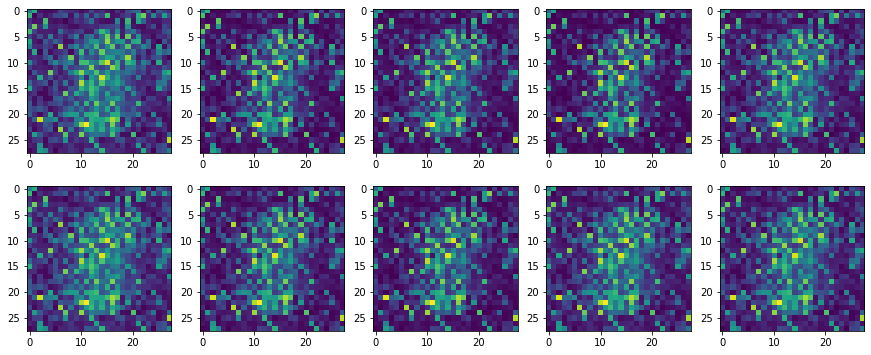

In [13]:
noise = tf.random.normal([10, 100])

output = gan_generator(noise)
output = np.squeeze(output.numpy())

plt.figure(figsize = (15, 6))
for i in range(1, 11):
    plt.subplot(2, 5, i)
    plt.imshow(output[i - 1])

* 결과를 보니 아마도 10 epoch의 학습만으로는 좋은 결과를 기대할 수 없는 듯 하다.
* 위 구현을 그대로 500 epoch 학습한 가중치를 한번 사용해보자.

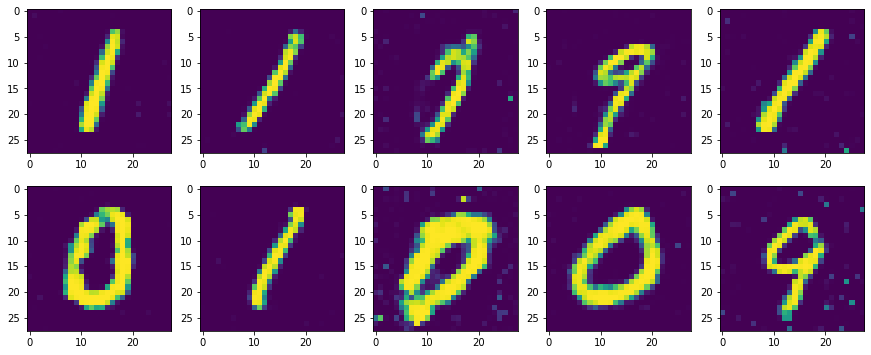

In [14]:
weight_path = os.getenv("HOME") + "/aiffel/conditional_generation/gan/GAN_500"

noise = tf.random.normal([10, 100])

gan_generator = GeneratorGAN()
gan_generator.load_weights(weight_path)

output = gan_generator(noise)
output = np.squeeze(output.numpy())

plt.figure(figsize = (15, 6))
for i in range(1, 11):
    plt.subplot(2, 5, i)
    plt.imshow(output[i - 1])

* 위에 보이는 10개의 결과 이미지는 서로 다른 숫자들이 시각화 됬을 수 있고, 아닐 수 있다.
* 이러한 방법으로는 내가 원하는 특정 숫자 하나를 출력하기 위해 수많은 입력을 넣어야 할 수 있다.
* 내가 원하는 숫자를 바로 얻어내기 위해 cGAN을 학습 시켜본다.

### 8. cGAN으로 MNIST 학습하기

* 이전 단계에서 구성한 GeneratorCGAN 및 DiscriminatorCGAN 모델 클래스를 이용한다.
* 위에서 실행했던 GAN 학습처럼 약간의 학습으로는 제대로 된 생성 결과를 얻을 수 없을 테니 이번에는 연습 삼아 1 epoch만 학습시킨다.

In [15]:
cgan_generator     = GeneratorCGAN()
cgan_discriminator = DiscriminatorCGAN()

@tf.function()
def cgan_step(real_images, labels):
    noise = tf.random.normal([real_images.shape[0], 100])
    
    with tf.GradientTape(persistent = True) as tape:
        fake_images = cgan_generator(noise, labels)
        
        real_out = cgan_discriminator(real_images, labels)
        fake_out = cgan_discriminator(fake_images, labels)
        
        gene_loss = generator_loss(fake_out)
        disc_loss = discriminator_loss(real_out, fake_out)
        
    gene_grad = tape.gradient(gene_loss, cgan_generator.trainable_variables)
    disc_grad = tape.gradient(disc_loss, cgan_discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_grad, cgan_generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_grad, cgan_discriminator.trainable_variables))
    
    return gene_loss, disc_loss

In [16]:
EPOCHS = 1

for epoch in range(1, EPOCHS + 1):
    for i, (images, labels) in enumerate(cgan_datasets):
        gene_loss, disc_loss = cgan_step(images, labels)
        
        if (i + 1) % 100 == 0:
            print(f"[{epoch} / {EPOCHS} EPOCHS, {i} ITER] G : {gene_loss}, D : {disc_loss}")

[1 / 1 EPOCHS, 99 ITER] G : 7.945955276489258, D : 0.005989313591271639
[1 / 1 EPOCHS, 199 ITER] G : 3.4521865844726562, D : 0.05380384996533394
[1 / 1 EPOCHS, 299 ITER] G : 3.8036930561065674, D : 0.06242621690034866
[1 / 1 EPOCHS, 399 ITER] G : 3.811880588531494, D : 0.11078117787837982


* 학습 과정에서 Generator 및 Discriminator에 레이블 정보만 추가로 입력했다는 점을 제외하면 위에서 학습한 GAN과 큰 차이는 없다.
* 위 코드로 짧게나마 학습시켜봤는데, 충분한 학습이 되기엔 더 많은 시간을 투자해야 한다.
* 뒤 에서 학습해야 할 것들이 많이 남아있으니, 시간을 아끼기 위해 위 코드로 500 epoch 학습한 가중치를 사용해보자.

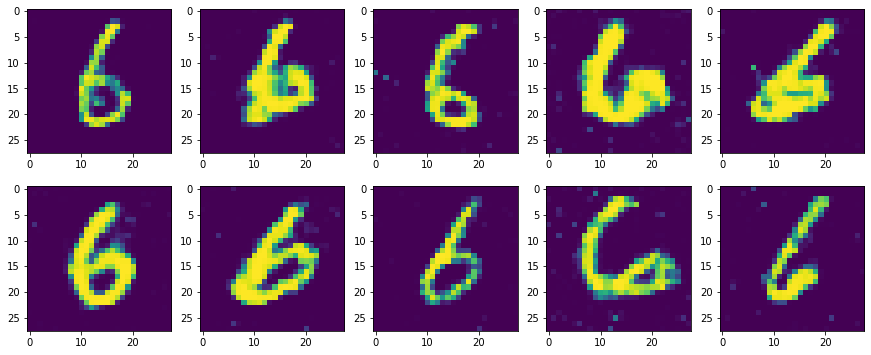

In [17]:
# 코드의 가장 윗줄에 있는 number 라는 변수에 원하는 숫자를 할당하고 코드를 실행시켜본다.
# 경고메시지가 출력된다면 그냥 무시해도 된다.
number = 6 # 원하는 숫자를 입력하기

weight_path = os.getenv("HOME") + "/aiffel/conditional_generation/cgan/CGAN_500"

noise = tf.random.normal([10, 100])

label = tf.one_hot(number, 10)
label = tf.expand_dims(label, axis = 0)
label = tf.repeat(label, 10, axis = 0)

generator = GeneratorCGAN()
generator.load_weights(weight_path)

output = generator(noise, label)
output = np.squeeze(output.numpy())

plt.figure(figsize = (15, 6))
for i in range(1, 11):
    plt.subplot(2, 5, i)
    plt.imshow(output[i - 1])

## 난 스케치를 할 테니 너는 채색을 하거라

### 0. 패키지 로딩하기

In [18]:
from tensorflow import image
from tensorflow import data
from tensorflow import losses
from tensorflow.keras import optimizers
from tensorflow.keras import layers, Input, Model
from tensorflow.keras.preprocessing.image import random_rotation

import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

### 1. 데이터 준비하기

* 이번에는 pix2pix 모델에 대해서 직접 구현하고 실험해본다. 
* 사용할 데이터셋은 Sketch2Pokemon이라는 데이터셋이다.
* 이 데이터셋은 학습용 데이터 셋에 830개의 이미지가 있으며, 각 (256x256) 크기의 이미지 쌍이 나란히 붙어 (256x512) 크기의 이미지로 구성되어 있다고 한다.

In [19]:
data_path = os.getenv("HOME") + "/aiffel/conditional_generation/pokemon_pix2pix_dataset/train/"
print("number of train examples :", len(os.listdir(data_path)))

number of train examples : 830


* 이번에는 각각의 이미지들이 어떻게 생겼는지 확인해본다.
* 학습용 데이터셋에서 임의로 6장을 선택하여 시각화한다.

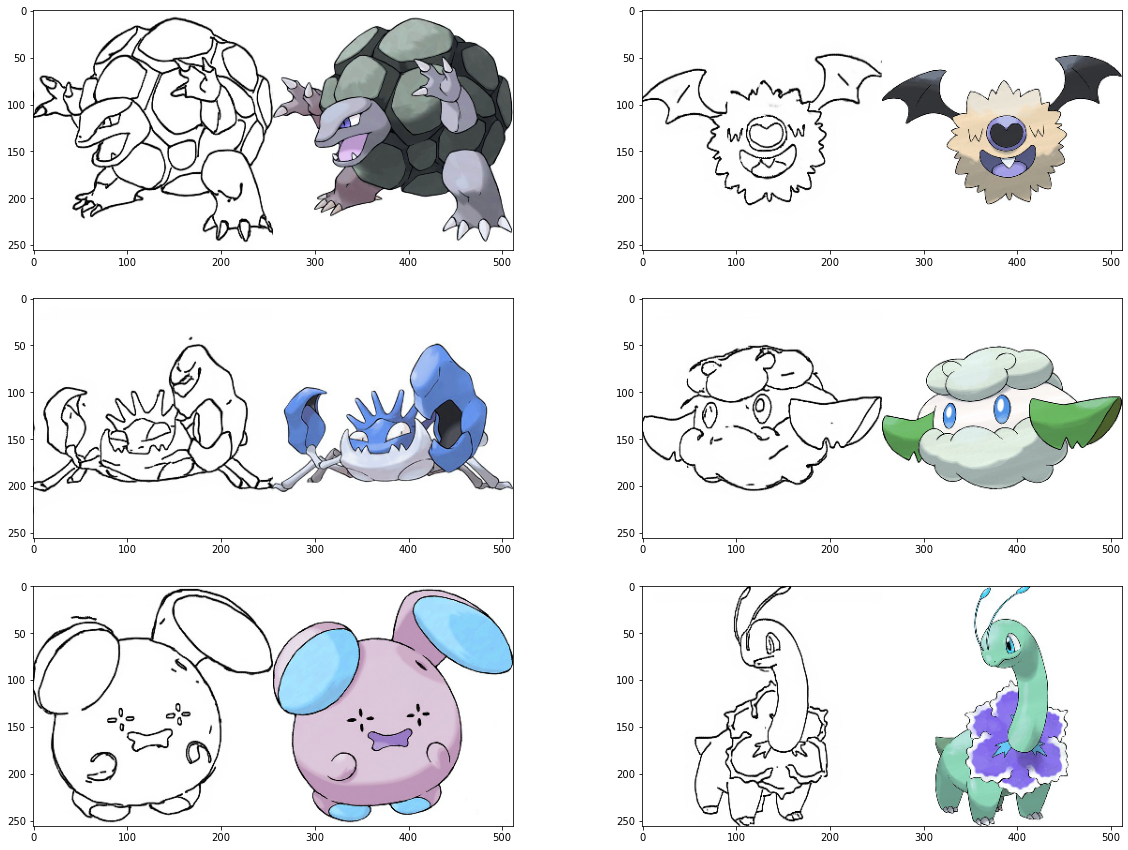

In [20]:
plt.figure(figsize = (20, 15))
for i in range(1, 7):
    f   = data_path + os.listdir(data_path)[np.random.randint(800)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3, 2, i)
    plt.imshow(img)

* 하나의 이미지에 포켓몬 스케치와 실제 포켓몬 이미지가 함께 포함되어 있음을 확인할 수 있다.
* 위 코드를 여러번 반복 실행해 보면 일부는 제대로 스케치 되지 않은 이미지도 확인할 수 있다.
* 출처를 확인해보니 직접 그려서 만든 데이터셋이 아닌 스케치 생성 모델을 이용해서 만들었다고 한다.
* 이미지를 하나 열어 크기를 확인해 보겠다.

In [21]:
f   = data_path + os.listdir(data_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


* (256, 512, 3)으로 확인된다.
* 모델 학습에 사용할 데이터를 (256, 256, 3) 크기의 2개 이미지로 분할하여 사용하면 되겠다.
* 아래 코드로 이미지를 나누었다.

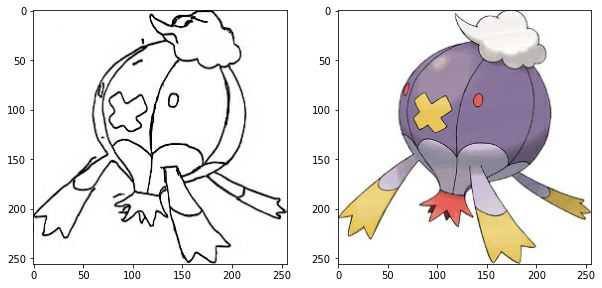

In [22]:
def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x / 127.5) - 1

def denormalize(x):
    x = (x + 1) * 127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w       = tf.shape(img)[1] // 2
    sketch  = img[:, :w, :]
    sketch  = tf.cast(sketch, tf.float32)
    colored = img[:, w:, :]
    colored = tf.cast(colored, tf.float32)
    return normalize(sketch), normalize(colored)

f = data_path + os.listdir(data_path)[1]
sketch, colored = load_img(f)

plt.figure(figsize = (10, 7))

plt.subplot(1, 2, 1)
plt.imshow(denormalize(sketch))

plt.subplot(1, 2, 2)
plt.imshow(denormalize(colored))

* 위와 같이 두 개 이미지로 나누었다.
* 첫 번째 스케치를 다음 단계에서 구성할 Pix2Pix 모델에 입력하여 두 번째 그림과 같은 채색된 이미지를 생성하는 것이 이번 단계의 목표이다.
* 앞서 봤듯이 학습에 사용할 수 있는 데이터의 수는 약 800개뿐이다.
* 학습에 사용하는 데이터의 다양성을 높이기 위해 여러 augmentation 방법을 적용해 보겠다.

In [23]:
@tf.function() # 빠른 텐서플로 연산을 위해 사용한다.
def apply_augmentation(sketch, colored):
    stacked = tf.concat([sketch, colored], axis = -1)
    
    _pad = tf.constant([[30, 30], [30, 30], [0, 0]])
    
    if tf.random.uniform(()) < 0.5:
        padded = tf.pad(stacked, _pad, "REFLECT")
        
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values = 1.)
        
    out = image.random_crop(padded, size = [256, 256, 6])
    
    out = image.random_flip_left_right(out)
    out = image.random_flip_up_down(out)
    
    if tf.random.uniform(()) < 0.5:
        degree = tf.random.uniform([], minval = 1, maxval = 4, dtype = tf.int32)
        out    = image.rot90(out, k = degree)
        
    return out[..., :3], out[..., 3:]

* apply_augmentation 함수는 스케치 및 채색된 2개 이미지를 입력으로 받아 여러 가지 연산을 두 이미지에 동일하게 적용한다.
* 위에서 정의한 apply_augmentation 함수에 두 이미지가 입력되면 어떠한 과정을 거치는지 순서대로 적어보자.
* 1. 두 이미지가 채널 축으로 연결된다. (tf.concat). 두 이미지가 각각 3채널인 경우 6채널이 된다.
* 2. 1의 결과가 각 50% 확률로 Refection padding 또는 constant padding이 30픽셀의 pad width 만큼 적용된다.
* 3. 2의 결과에서 (256, 256, 6) 크기를 가진 이미지를 임의로 잘라낸다. (tf.image.random_crop)
* 4. 3의 결과를 50% 확률로 가로로 뒤집는다. (tf.image.random_flip_left_right)
* 5. 4의 결과를 50% 확률로 세로로 뒤집는다. (tf.image.random_flip_up_down)
* 6. 5의 결과를 50% 확률로 회전시킨다. (tf.image.rot90)
* 위와 같이 구성한 함수를 데이터에 적용해 시각화 해본다.

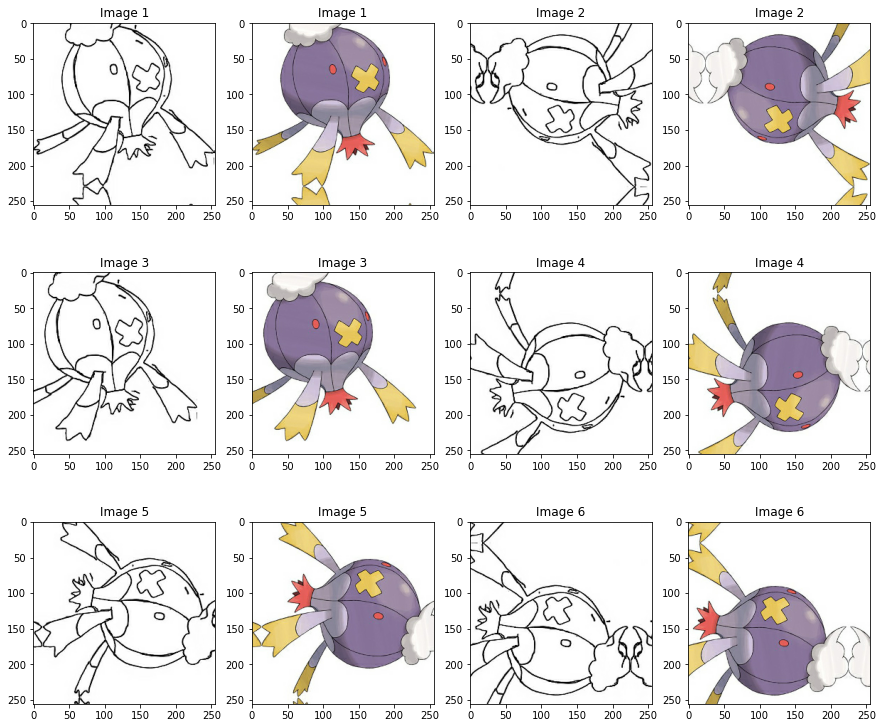

In [24]:
plt.figure(figsize = (15, 13))
img_n = 1

for i in range(1, 13, 2):
    augmented_sketch, augmented_colored = apply_augmentation(sketch, colored)
    
    plt.subplot(3, 4, i)
    plt.imshow(denormalize(augmented_sketch))
    plt.title(f"Image {img_n}")
    
    plt.subplot(3, 4, i + 1)
    plt.imshow(denormalize(augmented_colored))
    plt.title(f"Image {img_n}")
    
    img_n += 1

* 다양한 이미지가 생성된다.
* 여기서 사용한 augmentation 방법 외에 더 많은 방법을 활용한다면 더욱더 다양한 데이터셋을 만들어 좋은 일반화 결과를 기대해 볼 수 있다.
* 마지막으로 위 과정들을 학습 데이터에 적용하며, 잘 적용되었는지 하나의 이미지만 시각화하여 확인해본다.

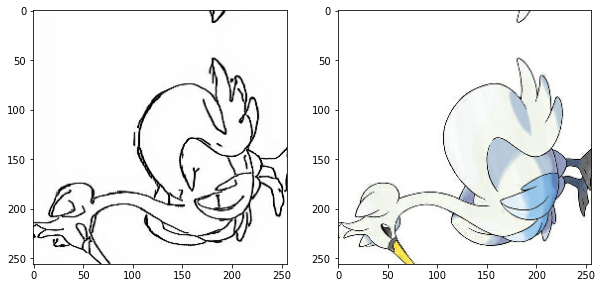

In [25]:
def get_train(img_path):
    sketch, colored = load_img(img_path)
    sketch, colored = apply_augmentation(sketch, colored)
    return sketch, colored

train_images = data.Dataset.list_files(data_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample          = train_images.take(1)
sample          = list(sample.as_numpy_iterator())
sketch, colored = (sample[0][0] + 1) * 127.5, (sample[0][1] + 1) * 127.5

plt.figure(figsize = (10, 5))

plt.subplot(1, 2, 1)
plt.imshow(sketch[0].astype(np.uint8))

plt.subplot(1, 2, 2)
plt.imshow(colored[0].astype(np.uint8))

### 2. Generator 구성하기

* Generator의 Encoder 부분을 구현해보자.
* 먼저 논문에서 "C64", "C128" 등으로 쓰여진 것과 같이 "Convolution → BatchNorm → LeakyReLU"의 3개 레이어로 구성된 기본적인 블록을 아래와 같이 하나의 레이어로 만들었다.

In [26]:
class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn = True):
        super(EncodeBlock, self).__init__()
        self.use_bn    = use_bn
        self.conv      = layers.Conv2D(n_filters, 4, 2, "same", use_bias = False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu     = layers.LeakyReLU(0.2)
        
    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

* __init__() 메서드에서 n_filters, use_bn를 설정하여 사용할 필터의 개수와 BatchNorm 사용 여부를 결정 할 수 있다.
* 이외 Convolution 레이어에서 필터의 크기(=4) 및 stride(=2)와 LeakyReLU 활성화의 slope coefficient(=0.2)는 모든 곳에서 고정되어 사용하므로 각각의 값을 지정했다.
* Encoder에 사용할 기본 블록을 구성했으니 이 블록을 여러번 가져다 사용하면 쉽게 Encoder를 구성할 수 있습니다. (아래 코드)

In [27]:
class Encoder(layers.Layer):
    def __init__(self):
        super(Encoder, self).__init__()
        filters = [64, 128, 256, 512, 512, 512, 512, 512]
        
        self.blocks = []
        for i, f in enumerate(filters):
            if i == 0:
                self.blocks.append(EncodeBlock(f, use_bn = False))
            else:
                self.blocks.append(EncodeBlock(f))
                
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
    
    def get_summary(self, input_shape = (256, 256, 3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

* 각 블록을 거치면서 사용할 필터의 개수를 filters라는 리스트에 지정했다.
* blocks이라는 리스트에는 사용할 블록들을 정의해 넣어두고, call() 메서드에서 차례대로 블록들을 통과한다.
* Encoder 첫 번째 블록에서는 BatchNorm을 사용하지 않는다.
* get_summary는 레이어가 제대로 구성되었는지 확인하기 위한 용도로 따로 만들어 놓았다.
* 위에서 구성한 Encoder에 (256,256,3) 크기의 데이터를 입력했을 때, 어떤 크기의 데이터가 출력되는지 살펴보자.
* 만들어 놓은 get_summary 메서드를 바로 불러오면 된다.

In [28]:
Encoder().get_summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
encode_block (EncodeBlock)   (None, 128, 128, 64)      3072      
_________________________________________________________________
encode_block_1 (EncodeBlock) (None, 64, 64, 128)       131584    
_________________________________________________________________
encode_block_2 (EncodeBlock) (None, 32, 32, 256)       525312    
_________________________________________________________________
encode_block_3 (EncodeBlock) (None, 16, 16, 512)       2099200   
_________________________________________________________________
encode_block_4 (EncodeBlock) (None, 8, 8, 512)         4196352   
_________________________________________________________________
encode_block_5 (EncodeBlock) (None, 4, 4, 512)         419635

* 블록을 통과할수록 (width, height) 크기는 반씩 줄어들고, 사용된 필터의 수는 최대 512개로 늘어나 최종 (1,1,512)로 알맞은 크기가 출력됨을 확인 할 수 있다.
* 이번엔 Decoder를 구현한다.
* Encoder와 마찬가지로 사용할 기본 블록을 정의하고, 이 블록을 여러번 반복하여 Decoder를 만든다.

In [29]:
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout = True):
        super(DecodeBlock, self).__init__()
        self.dropout   = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias = False)
        self.batchnorm = layers.BatchNormalization()
        self.relu      = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(0.5)(x)
        return self.relu(x)
    
    
class Decoder(layers.Layer):
    def __init__(self):
        super(Decoder, self).__init__()
        filters = [512, 512, 512, 512, 256, 128, 64]
        
        self.blocks = []
        for i, f in enumerate(filters):
            if i < 3:
                self.blocks.append(DecodeBlock(f))
            else:
                self.blocks.append(DecodeBlock(f, dropout = False))
                
        self.blocks.append(layers.Conv2DTranspose(3, 4, 2, "same", use_bias = False))
        
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
    
    def get_summary(self, input_shape = (1, 1, 256)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

* 처음 세 개의 블록에서만 Dropout을 사용했으며, 마지막 convolution에는 3개의 필터를 사용해 출력하는 것을 확인할 수 있다.
* 마찬가지로 (1, 1, 512) 크기의 데이터가 입력되었을 때, 어떤 크기가 출력되는지 확인해본다.

In [30]:
Decoder().get_summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1, 1, 256)]       0         
_________________________________________________________________
decode_block (DecodeBlock)   (None, 2, 2, 512)         2099200   
_________________________________________________________________
decode_block_1 (DecodeBlock) (None, 4, 4, 512)         4196352   
_________________________________________________________________
decode_block_2 (DecodeBlock) (None, 8, 8, 512)         4196352   
_________________________________________________________________
decode_block_3 (DecodeBlock) (None, 16, 16, 512)       4196352   
_________________________________________________________________
decode_block_4 (DecodeBlock) (None, 32, 32, 256)       2098176   
_________________________________________________________________
decode_block_5 (DecodeBlock) (None, 64, 64, 128)       5248

* (width, height) 크기가 점점 늘어나고 사용 필터의 수는 점점 줄어들어 최종 (256, 256, 3) 크기로 알맞게 출력되었다.
* 위에서 구성한 Encoder와 Decoder를 연결시키면 Encoder에서 (256, 256, 3) 입력이 (1, 1, 512)로 변환되고,
* Decoder를 통과해 다시 원래 입력 크기와 같은 (256, 256, 3)의 결과를 얻을 수 있다.
* 스케치를 입력으로 이런 연산 과정을 통해 채색된 이미지 출력을 얻을 수 있다.
* 아래 코드와 같이 tf.keras.Model을 상속받아 Encoder와 Decoder를 연결해 Generator를 구성했다.

In [31]:
class EncoderDecoderGenerator(Model):
    def __init__(self):
        super(EncoderDecoderGenerator, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
        
    def call(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
    def get_summary(self, input_shape = (256, 256, 3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

In [32]:
EncoderDecoderGenerator().get_summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
encoder_1 (Encoder)          (None, 1, 1, 512)         19544576  
_________________________________________________________________
decoder_1 (Decoder)          (None, 256, 256, 3)       19542784  
Total params: 39,087,360
Trainable params: 39,076,480
Non-trainable params: 10,880
_________________________________________________________________


### 3. Generator 재구성하기

* 지금까지 Encoder와 Decoder를 연결시켜 Generator를 만들어 봤다.
* 하지만 Pix2Pix의 Generator 구조는 두 가지를 제안했다.
* 더 좋은 결과를 기대하기 위해 이전에 구현했던 것들을 조금 수정하여 U-Net 구조를 만들고 실험해본다.
* 먼저 Encoder 및 Decoder에 사용되는 기본적인 블록은 이전에 아래 코드와 같이 구현했었다.
* 참고로 아래 단락부터는 두 가지 구조를 각각 "Encoder-Decoder Generator" 및 "U-Net Generator"라는 용어로 구분하여 사용했다.

In [33]:
class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn = True):
        super(EncodeBlock, self).__init__()
        self.use_bn    = use_bn
        self.conv      = layers.Conv2D(n_filters, 4, 2, "same", use_bias = False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu     = layers.LeakyReLU(0.2)
        
    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)
    
    
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout = True):
        super(DecodeBlock, self).__init__()
        self.dropout   = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias = False)
        self.batchnorm = layers.BatchNormalization()
        self.relu      = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(0.5)(x)
        return self.relu(x)

* 여기서 특별히 수정해야 할 부분은 없다. 그대로 가져다가 사용한다.
* 정의된 블록들을 이용해 한 번에 U-Net Generator를 정의한다.
* 아래 모델의 __init__() 메서드에서 Encoder 및 Decoder에서 사용할 모든 블록들을 정의해 놓고, call()에서 forward propagation 하도록 한다.
* 이전 구현에는 없었던 skip connection이 call() 내부에서 어떻게 구현되었는지 잘 확인해보자.

In [34]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64, 128, 256, 512, 512, 512, 512, 512]
        decode_filters = [512, 512, 512, 512, 256, 128, 64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn = False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
                
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout = False))
                
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias = False)
        
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
            
        features = features[:-1]
        
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
            
        x = self.last_conv(x)
        return x
    
    def get_summary(self, input_shape = (256, 256, 3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

* 먼저, __init__()에서 정의된 encode_blocks 및 decode_blocks가 call() 내부에서 차례대로 사용되어 Encoder 및 Decoder 내부 연산을 수행한다.
* 이때, Encoder와 Decoder 사이의 skip connection을 위해 features 라는 리스트를 만들고 Encoder 내에서 사용된 각 블록들의 출력을 차례대로 담았다.
* 이후 Encoder의 최종 출력이 Decoder의 입력으로 들어가면서 다시 한번 각각의 Decoder 블록들을 통과하는데,
* features 리스트에 있는 각각의 출력들이 Decoder 블록 연산 후 함께 연결되어 다음 블록의 입력으로 사용된다.
* 코드의 call() 내에서 "features = features[:-1]"가 필요한 이유는 Skip connection을 위해 만들어진 features 리스트에는 Encoder 내 각 블록의 출력이 들어있는데, Encoder의 마지막 출력 (feature 리스트의 마지막 항목)은 Decoder로 직접 입력되므로 skip connection의 대상이 아니기 때문이다.
* 그리고 코드의 call() 내의 Decoder 연산 부분에서 features[::-1]가 필요한 이유는 Skip connection은 encoder 내 첫 번째 블록의 출력이 Decoder의 마지막 블록에 연결되고, Encoder 내 두번째 블록의 출력이 Decoder의 뒤에서 2번째 블록에 연결되는 등 대칭을 이루기 때문이다. features에는 Encoder 블록들의 출력들이 순서대로 쌓여있고, 이를 Decoder에서 차례때로 사용하기 위해서 features의 역순으로 연결한다.
* 이제 Generator 구현이 끝났다.
* 마지막으로 완성된 U-Net 구조 Generator 내부의 각 출력이 적절한지 확인해본다.

In [35]:
UNetGenerator().get_summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
encode_block_16 (EncodeBlock)   (None, 128, 128, 64) 3072        input_4[0][0]                    
__________________________________________________________________________________________________
encode_block_17 (EncodeBlock)   (None, 64, 64, 128)  131584      encode_block_16[0][0]            
__________________________________________________________________________________________________
encode_block_18 (EncodeBlock)   (None, 32, 32, 256)  525312      encode_block_17[0][0]            
____________________________________________________________________________________________

### 4. Discriminator 구성하기

* Discriminator에 사용할 기본적인 블록부터 만든다.

In [36]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride = 2, custom_pad = False, use_bn = True, act = True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn     = use_bn
        self.act        = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv    = layers.Conv2D(n_filters, 4, stride, "valid", use_bias = False)
        else:
            self.conv    = layers.Conv2D(n_filters, 4, stride, "same",  use_bias = False)
            
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu     = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
            
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
            
        return x

* __init__() 에서 필요한 만큼 많은 설정을 가능하게끔 했다.
* 필터의 수(n_filters), 필터가 순회하는 간격(stride), 출력 feature map의 크기를 조절할 수 있도록 하는 패딩 설정(custom_pad), BatchNorm의 사용 여부(use_bn), 활성화 함수 사용 여부(act)가 설정 가능하다.

* Discriminator를 표현한 그림을 찾아보면 마지막 2개 블록의 출력은 입력에 비해 (width, height) 크기가 1씩 감소한다는 것을 알 수 있다.
* 1씩 감소시키기 위한 방법을 자세히 보자.
* (128, 128, 32) 크기의 입력이 layers.ZeroPadding2D()를 통과하면, width 및 height의 양쪽 면에 각각 1씩 패딩되어 총 2만큼 크기가 늘어난다.
* 출력 : (130, 130, 32)
* 패딩하지 않고 필터 크기 4 및 간격(stride) 1의 convolution 레이어를 통과하면 width 및 height 가 3씩 줄어든다.
* 이는 OutSize = (InSize + 2 ∗ PadSize − FilterSize) / Stride + 1의 식으로 계산할 수 있다.
* 채널 수는 사용한 필터 개수와 같다.
* 출력 : (127, 127, 64)
* 이 외 다른 레이어(BatchNorm, LeakyReLU)는 출력의 크기에 영향을 주지 않는다.
* 간단하게 코드를 작성하여 각 출력의 크기가 맞는지 확인해 본다.

In [37]:
inputs = Input((128, 128, 32))

out = layers.ZeroPadding2D()(inputs)
out = layers.Conv2D(64, 4, 1, "valid", use_bias = False)(out)
out = layers.BatchNormalization()(out)
out = layers.LeakyReLU(0.2)(out)

Model(inputs, out).summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 128, 128, 32)]    0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 130, 130, 32)      0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 127, 127, 64)      32768     
_________________________________________________________________
batch_normalization_45 (Batc (None, 127, 127, 64)      256       
_________________________________________________________________
leaky_re_lu_24 (LeakyReLU)   (None, 127, 127, 64)      0         
Total params: 33,024
Trainable params: 32,896
Non-trainable params: 128
_________________________________________________________________


* 이런 코드와 비슷한 설정으로 (width, height) 크기를 1씩 감소시킬 수 있다.
* 마지막 2개 블록은 출력의 크기가 1씩 감소하므로 이런 방식을 적용하면 된다.
* Pix2Pix의 Discriminator가 70x70 PatchGAN을 사용하기 때문에 최종 출력을 (30, 30) 크기로 맞추느라 위와 같이 조금 복잡한 과정을 설명했다.
* 사용할 기본적인 블록을 만들었으니 이를 이용해 바로 Discriminator를 만들어본다.

In [38]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1  = layers.Concatenate()
        self.block2  = DiscBlock(n_filters = 64,  stride = 2, custom_pad = False, use_bn = False, act = True)
        self.block3  = DiscBlock(n_filters = 128, stride = 2, custom_pad = False, use_bn = True,  act = True)
        self.block4  = DiscBlock(n_filters = 256, stride = 2, custom_pad = False, use_bn = True,  act = True)
        self.block5  = DiscBlock(n_filters = 512, stride = 1, custom_pad = True,  use_bn = True,  act = True)
        self.block6  = DiscBlock(n_filters = 1,   stride = 1, custom_pad = True,  use_bn = False, act = False)
        self.sigmoid = layers.Activation("sigmoid")
        
        # filters     = [64, 128, 256, 512, 1]
        # self.blocks = [layers.Concatenate()]
        # for i, f in enumerate(filters):
        #     self.blocks.append(DiscBlock(
        #         n_filters  = f,
        #         strides    = 2 if i < 3 else 1,
        #         custom_pad = False if i < 3 else True,
        #         use_bn     = False if i == 0 and i == 4 else True,
        #         act        = True if i < 4 else False
        #     ))
        
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape = (256, 256, 3), y_shape = (256, 256, 3)):
        x, y = Input(x_shape), Input(y_shape)
        return Model((x, y), self.call(x, y)).summary()

* __init__() 내부에서 사용할 블록들을 정의했는데, 이전의 구현들처럼 (위 코드의 주석 처리된 부분과 같이) for loop로 간편하게 블록을 만들 수도 있지만, 쉽게 코드를 읽게끔 총 6개 블록을 각각 따로 만들었다.
* 첫 번째 블록은 단순한 연결(concat)을 수행하며, Discriminator의 최종 출력은 sigmoid 활성화를 사용했다.
* 각 블록의 출력 크기가 알맞게 되었는지 아래 코드로 확인해본다.

In [39]:
Discriminator().get_summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_7 (Concatenate)     (None, 256, 256, 6)  0           input_6[0][0]                    
                                                                 input_7[0][0]                    
__________________________________________________________________________________________________
disc_block (DiscBlock)          (None, 128, 128, 64) 6144        concatenate_7[0][0]        

* 시험 삼아 임의의 (256, 256, 3) 크기의 입력을 넣어 나오는 (30, 30) 출력을 시각화해본다.

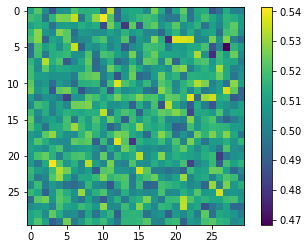

In [40]:
x = tf.random.normal([1,  256, 256, 3])
y = tf.random.uniform([1, 256, 256, 3])

disc_out = Discriminator()(x, y)
plt.imshow(disc_out[0, ..., 0])
plt.colorbar()

* 위 (30, 30) 크기를 갖는 결과 이미지의 각 픽셀값은 원래 입력의 (70, 70) 패치에 대한 분류 결과이다.
* 전체 입력의 크기가 (256, 256) 이므로, 각각의 (70, 70) 패치는 원래 입력상에서 많이 겹쳐있다.
* 각각의 픽셀값은 sigmoid 함수의 결괏값이므로 0 ~ 1 사이의 값을 가지며, 진짜 및 가짜 데이터를 판별해내는 데 사용한다.
* 드디어 Pix2Pix를 구성하는 Generator와 Discriminator의 구현이 끝났다.
* 다음은 본격적인 모델 학습을 진행해본다.

### 5. 학습 및 테스트하기

* 이번 단계에서는 구현된 Generator와 Discriminator를 학습시켜보고, 스케치를 입력으로 채색된 이미지를 생성해본다.
* 먼저 학습에 필요한 손실함수부터 정의한다.
* 레이블 정보만 있는 입력에 대해 여러 손실함수를 사용해 실제 이미지를 만들어 낸 결과는, 일반적인 GAN의 손실함수에 L1을 추가로 이용했을 때 가장 실제에 가까운 이미지를 생성한다고 한다.
* 이번 실험에서도 두 가지 손실 함수를 모두 사용해본다.

In [41]:
bce = losses.BinaryCrossentropy(from_logits = False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss   = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

* Generator 및 Discriminator의 손실 계산을 각각 정의했다.
* Generator의 손실함수 (위 코드의 get_gene_loss)는 총 3개의 입력이 있다. 이 중 fake_disc는 Generator가 생성한 가짜 이미지를 Discriminator에 입력하여 얻어진 값이며, 실제 이미지를 뜻하는 "1"과 비교하기 위해 tf.ones_like()를 사용합니다. 또한 L1 손실을 계산하기 위해 생성한 가짜 이미지(fake_output)와 실제 이미지(real_output) 사이의 MAE(Mean Absolute Error)를 계산한다.
* Discriminator의 손실함수 (위 코드의 get_disc_loss)는 2개의 입력이 있으며, 이들은 가짜 및 진짜 이미지가 Discriminator에 각각 입력되어 얻어진 값입니다. Discriminator는 실제 이미지를 잘 구분해 내야 하므로 real_disc는 "1"로 채워진 벡터와 비교하고, fake_disc는 "0"으로 채워진 벡터와 비교한다.
* 사용할 optimizer는 논문과 동일하게 설정했다.

In [42]:
gene_opt = optimizers.Adam(2e-4, beta_1 = 0.5, beta_2 = 0.999)
disc_opt = optimizers.Adam(2e-4, beta_1 = 0.5, beta_2 = 0.999)

* 하나의 배치 크기만큼 데이터를 입력했을 때 가중치를 1회 업데이트하는 과정은 아래와 같이 구현했다.

In [43]:
@tf.function
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_colored = generator(sketch, training = True)
        
        # Discriminator 예측
        fake_disc = discriminator(sketch, fake_colored, training = True)
        real_disc = discriminator(sketch, real_colored, training = True)
        
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss    = gene_loss + (100 * l1_loss) # L1 손실 반영 λ = 100
        
        # Discriminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
        
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

* 전반적인 학습 과정은 앞서 진행했었던 cGAN 학습과 크게 다르지 않다.
* 다만 위 코드의 gene_total_loss 계산 라인에서 최종 Generator 손실을 계산할 때, L1 손실에 100을 곱한 부분을 확인할 수 있다.
* λ는 학습 과정에서 L1 손실을 얼마나 반영할 것인지를 나타내며 논문에서는 λ = 100을 사용했다.
* 앞서 정의한 함수를 이용해서 학습을 진행한다.

In [44]:
EPOCHS = 10

generator     = UNetGenerator()
discriminator = Discriminator()

for epoch in range(1, EPOCHS + 1):
    for i, (sketch, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sketch, colored)
        
        # 10회 반복마다 손실을 출력한다.
        if (i + 1) % 10 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i + 1}] \
                  \nGenerator_loss : {g_loss.numpy():.4f} \
                  \nL1_loss : {l1_loss.numpy():.4f} \
                  \nDiscriminator_loss : {d_loss.numpy():.4f}", 
                  end = "\n\n")

EPOCH[1] - STEP[10]                   
Generator_loss : 0.9509                   
L1_loss : 0.4207                   
Discriminator_loss : 1.2667

EPOCH[1] - STEP[20]                   
Generator_loss : 1.0767                   
L1_loss : 0.2972                   
Discriminator_loss : 1.3113

EPOCH[1] - STEP[30]                   
Generator_loss : 0.8672                   
L1_loss : 0.2749                   
Discriminator_loss : 1.2445

EPOCH[1] - STEP[40]                   
Generator_loss : 1.4103                   
L1_loss : 0.2782                   
Discriminator_loss : 1.1401

EPOCH[1] - STEP[50]                   
Generator_loss : 0.8163                   
L1_loss : 0.2189                   
Discriminator_loss : 1.1128

EPOCH[1] - STEP[60]                   
Generator_loss : 1.3644                   
L1_loss : 0.2633                   
Discriminator_loss : 0.4868

EPOCH[1] - STEP[70]                   
Generator_loss : 1.9599                   
L1_loss : 0.2100                   


EPOCH[3] - STEP[170]                   
Generator_loss : 3.1779                   
L1_loss : 0.2852                   
Discriminator_loss : 0.1201

EPOCH[3] - STEP[180]                   
Generator_loss : 4.0982                   
L1_loss : 0.2751                   
Discriminator_loss : 1.9714

EPOCH[3] - STEP[190]                   
Generator_loss : 2.5936                   
L1_loss : 0.2493                   
Discriminator_loss : 0.6173

EPOCH[3] - STEP[200]                   
Generator_loss : 1.3706                   
L1_loss : 0.2955                   
Discriminator_loss : 1.4399

EPOCH[4] - STEP[10]                   
Generator_loss : 3.2693                   
L1_loss : 0.2582                   
Discriminator_loss : 0.3358

EPOCH[4] - STEP[20]                   
Generator_loss : 1.8179                   
L1_loss : 0.2497                   
Discriminator_loss : 0.3203

EPOCH[4] - STEP[30]                   
Generator_loss : 1.8524                   
L1_loss : 0.2579                

EPOCH[6] - STEP[130]                   
Generator_loss : 1.5751                   
L1_loss : 0.2261                   
Discriminator_loss : 0.3297

EPOCH[6] - STEP[140]                   
Generator_loss : 1.3094                   
L1_loss : 0.3633                   
Discriminator_loss : 0.4589

EPOCH[6] - STEP[150]                   
Generator_loss : 2.3557                   
L1_loss : 0.2918                   
Discriminator_loss : 0.8323

EPOCH[6] - STEP[160]                   
Generator_loss : 0.6332                   
L1_loss : 0.2268                   
Discriminator_loss : 1.2816

EPOCH[6] - STEP[170]                   
Generator_loss : 2.2530                   
L1_loss : 0.2520                   
Discriminator_loss : 0.4928

EPOCH[6] - STEP[180]                   
Generator_loss : 0.4431                   
L1_loss : 0.2269                   
Discriminator_loss : 1.4880

EPOCH[6] - STEP[190]                   
Generator_loss : 2.1194                   
L1_loss : 0.2497             

EPOCH[9] - STEP[90]                   
Generator_loss : 0.5774                   
L1_loss : 0.2340                   
Discriminator_loss : 1.0337

EPOCH[9] - STEP[100]                   
Generator_loss : 0.8476                   
L1_loss : 0.3046                   
Discriminator_loss : 0.7615

EPOCH[9] - STEP[110]                   
Generator_loss : 1.6302                   
L1_loss : 0.2753                   
Discriminator_loss : 0.3432

EPOCH[9] - STEP[120]                   
Generator_loss : 0.6959                   
L1_loss : 0.3143                   
Discriminator_loss : 0.8165

EPOCH[9] - STEP[130]                   
Generator_loss : 1.2735                   
L1_loss : 0.2310                   
Discriminator_loss : 0.4192

EPOCH[9] - STEP[140]                   
Generator_loss : 1.3247                   
L1_loss : 0.2260                   
Discriminator_loss : 0.4418

EPOCH[9] - STEP[150]                   
Generator_loss : 0.8880                   
L1_loss : 0.2327              

* 아래 코드로 짧게나마 학습해 본 모델에 채색을 시켜보자. 아마 마음에 안 들 것이다.

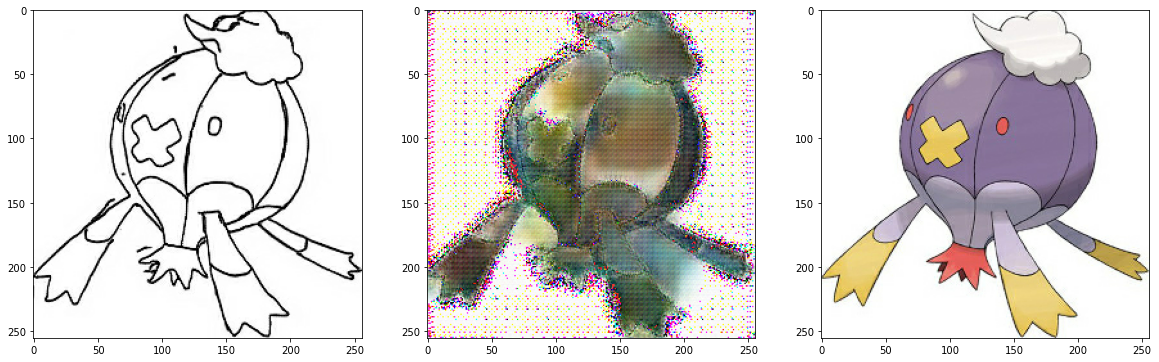

In [45]:
test_ind = 1

f = data_path + os.listdir(data_path)[test_ind]
sketch, colored = load_img(f)

pred = generator(tf.expand_dims(sketch, 0))
pred = denormalize(pred)

plt.figure(figsize = (20, 10))

plt.subplot(1, 3, 1)
plt.imshow(denormalize(sketch))

plt.subplot(1, 3, 2)
plt.imshow(pred[0])

plt.subplot(1, 3, 3)
plt.imshow(denormalize(colored))

* 데이터셋을 제공한 출처를 보면, Pix2Pix로 128 epoch 학습 후 테스트 결과도 별로라고 한다.
* 이전 10 epoch 학습의 결과보다는 훨씬 낫지만, 조금 오래 학습했어도 채색해야 할 전체적인 색감 정도만 학습되며 아직까지 세부적으로는 제대로 채색되지 않다는 것을 확인할 수 있다.

# 프로젝트

## Segmentation map으로 도로 이미지 만들기

* 이전 Pix2Pix 논문에서 제시한 결과 중에 도로의 레이블 정보를 활용해 이미지를 생성해낸 결과가 있었다.
* 이번 프로젝트는 위와 같은 데이터셋을 이용해 Pix2Pix를 학습시켜보는 것이다.
* 데이터셋은 1000개의 학습용 이미지 및 5개의 평가 이미지로 구성되어 있다.
* 이전 포켓몬 데이터에서 사용했던 스케치와는 조금 다른 레이블 정보 이미지를 입력으로 사용하기 때문에, 전처리 과정에 대해 약간의 혼란이 있을 수 있지만 크게 다른 과정은 없다.

### 프로젝트 수행
* 프로젝트를 진행하면서 필수로 수행해야 할 사항은 다음과 같다.
* 1. 데이터에 한 가지 이상의 augmentation 방법을 적용하여 학습한다. (어떠한 방법을 사용했는지 적어주세요.)
* 2. 이전에 구현했던 두 개의 Generator 중 Encoder와 Decoder간에 skip connection이 있는 U-Net Generator를 사용한다.
* 3. 모델 학습 후, 학습된 Generator를 이용해 테스트한다. 테스트 데이터는 다운받았던 "val" 폴더 내 이미지를 사용한다.
* 4. 1개 이상의 이미지에 대해 테스트 과정을 거친 후 그 결과를 스케치, 생성된 사진, 실제 사진 순서로 나란히 시각화한다.
* 5. 모델을 충분히 학습하기에 시간이 부족할 수 있다. 적어도 10 epoch 이상 학습하며 중간 손실 값에 대한 로그를 남겨본다. 좋은 결과를 얻기 위해선 긴 학습 시간이 필요하므로 테스트 결과는 만족스럽지 않아도 괜찮다.

### 0. 패키지 로딩하기

In [46]:
from tensorflow import image
from tensorflow import data
from tensorflow import losses
from tensorflow.keras import optimizers
from tensorflow.keras import layers, Input, Model
from tensorflow.keras.preprocessing.image import random_rotation

import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

### 1. 데이터 준비하기

In [47]:
data_path = os.getenv("HOME") + "/aiffel/conditional_generation/cityscapes/train/"
print("number of train examples :", len(os.listdir(data_path)))

number of train examples : 1000


* 이번에는 각각의 이미지들이 어떻게 생겼는지 확인해본다.
* 학습용 데이터셋에서 임의로 6장을 선택하여 시각화한다.

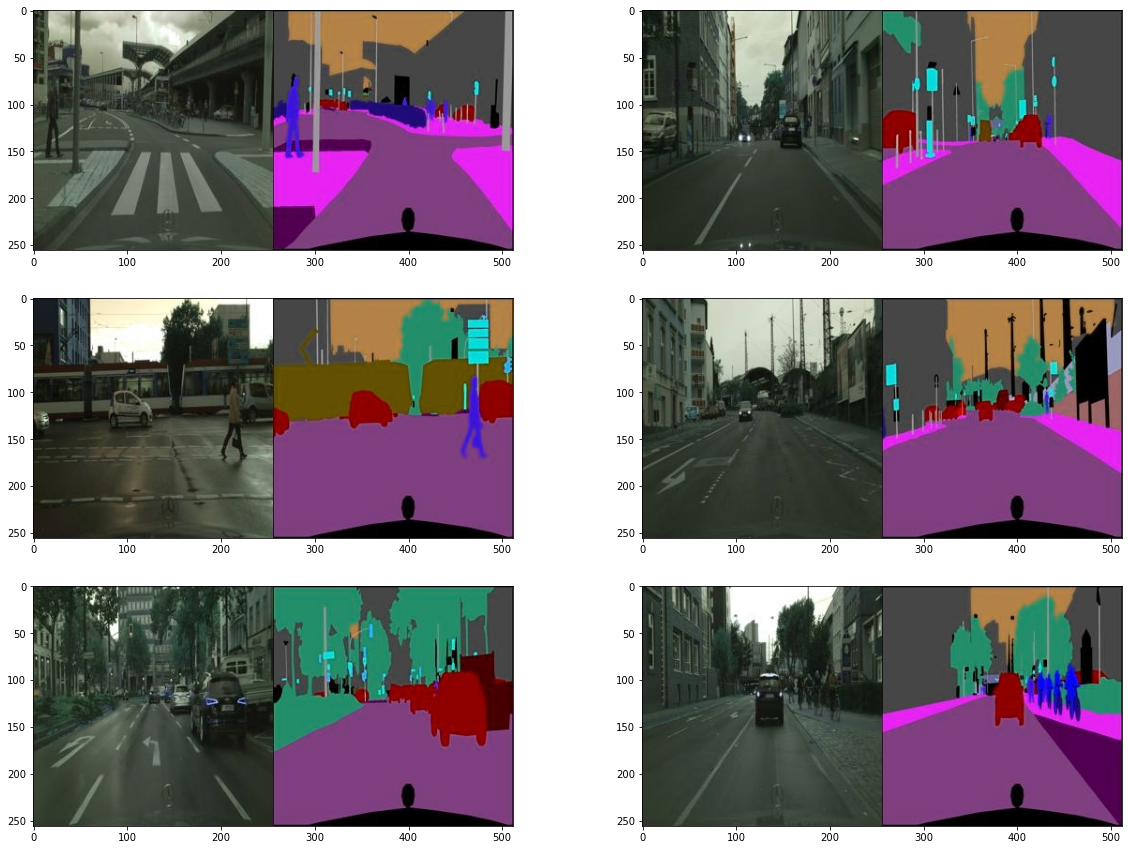

In [48]:
plt.figure(figsize = (20, 15))
for i in range(1, 7):
    f   = data_path + os.listdir(data_path)[np.random.randint(800)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3, 2, i)
    plt.imshow(img)

* 하나의 이미지에 스케치와 실제 이미지가 함께 포함되어 있음을 확인할 수 있다.
* 이미지를 하나 열어 크기를 확인해 보겠다.

In [49]:
f   = data_path + os.listdir(data_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


* (256, 512, 3)으로 확인된다.
* 모델 학습에 사용할 데이터를 (256, 256, 3) 크기의 2개 이미지로 분할하여 사용하면 되겠다.
* 아래 코드로 이미지를 나누었다.

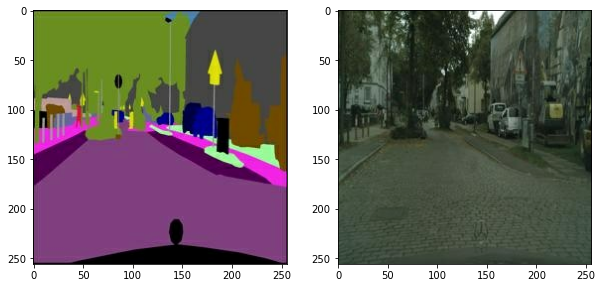

In [50]:
def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x / 127.5) - 1

def denormalize(x):
    x = (x + 1) * 127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w       = tf.shape(img)[1] // 2
    colored = img[:, :w, :]
    colored = tf.cast(colored, tf.float32)
    sketch  = img[:, w:, :]
    sketch  = tf.cast(sketch, tf.float32)
    return normalize(sketch), normalize(colored)

f = data_path + os.listdir(data_path)[1]
sketch, colored = load_img(f)

plt.figure(figsize = (10, 7))

plt.subplot(1, 2, 1)
plt.imshow(denormalize(sketch))

plt.subplot(1, 2, 2)
plt.imshow(denormalize(colored))

* 위와 같이 두 개 이미지로 나누었다.
* 첫 번째 스케치를 다음 단계에서 구성할 Pix2Pix 모델에 입력하여 두 번째 그림과 같은 채색된 이미지를 생성하는 것이 이번 단계의 목표이다.
* 앞서 봤듯이 학습에 사용할 수 있는 데이터의 수는 약 1000개뿐이다.
* 학습에 사용하는 데이터의 다양성을 높이기 위해 여러 augmentation 방법을 적용해 보겠다.

In [51]:
@tf.function() # 빠른 텐서플로 연산을 위해 사용한다.
def apply_augmentation(sketch, colored):
    stacked = tf.concat([sketch, colored], axis = -1)
    
    _pad = tf.constant([[30, 30], [30, 30], [0, 0]])
    
    if tf.random.uniform(()) < 0.5:
        padded = tf.pad(stacked, _pad, "REFLECT")
        
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values = 1.)
        
    out = image.random_crop(padded, size = [256, 256, 6])
    
    out = image.random_flip_left_right(out)
    out = image.random_flip_up_down(out)
    
    if tf.random.uniform(()) < 0.5:
        degree = tf.random.uniform([], minval = 1, maxval = 4, dtype = tf.int32)
        out    = image.rot90(out, k = degree)
        
    return out[..., :3], out[..., 3:]

* apply_augmentation 함수는 스케치 및 채색된 2개 이미지를 입력으로 받아 여러 가지 연산을 두 이미지에 동일하게 적용한다.
* 위에서 정의한 apply_augmentation 함수에 두 이미지가 입력되면 어떠한 과정을 거치는지 순서대로 적어보자.
* 1. 두 이미지가 채널 축으로 연결된다. (tf.concat). 두 이미지가 각각 3채널인 경우 6채널이 된다.
* 2. 1의 결과가 각 50% 확률로 Refection padding 또는 constant padding이 30픽셀의 pad width 만큼 적용된다.
* 3. 2의 결과에서 (256, 256, 6) 크기를 가진 이미지를 임의로 잘라낸다. (tf.image.random_crop)
* 4. 3의 결과를 50% 확률로 가로로 뒤집는다. (tf.image.random_flip_left_right)
* 5. 4의 결과를 50% 확률로 세로로 뒤집는다. (tf.image.random_flip_up_down)
* 6. 5의 결과를 50% 확률로 회전시킨다. (tf.image.rot90)
* 위와 같이 구성한 함수를 데이터에 적용해 시각화 해본다.

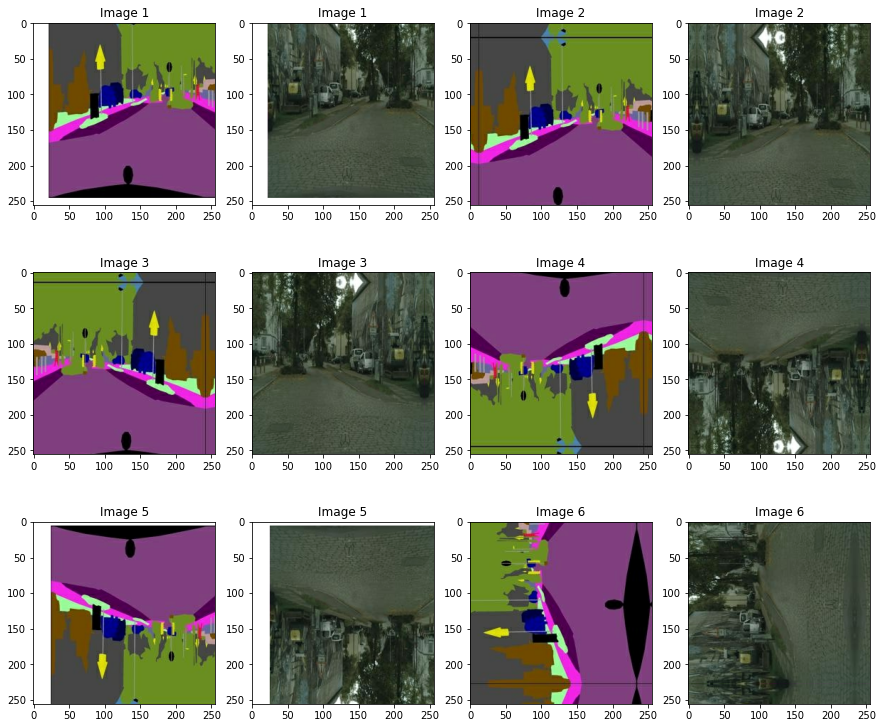

In [52]:
plt.figure(figsize = (15, 13))
img_n = 1

for i in range(1, 13, 2):
    augmented_sketch, augmented_colored = apply_augmentation(sketch, colored)
    
    plt.subplot(3, 4, i)
    plt.imshow(denormalize(augmented_sketch))
    plt.title(f"Image {img_n}")
    
    plt.subplot(3, 4, i + 1)
    plt.imshow(denormalize(augmented_colored))
    plt.title(f"Image {img_n}")
    
    img_n += 1

* 다양한 이미지가 생성된다.
* 여기서 사용한 augmentation 방법 외에 더 많은 방법을 활용한다면 더욱더 다양한 데이터셋을 만들어 좋은 일반화 결과를 기대해 볼 수 있다.
* 마지막으로 위 과정들을 학습 데이터에 적용하며, 잘 적용되었는지 하나의 이미지만 시각화하여 확인해본다.

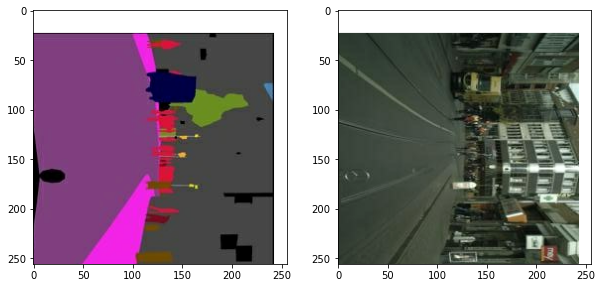

In [53]:
def get_train(img_path):
    sketch, colored = load_img(img_path)
    sketch, colored = apply_augmentation(sketch, colored)
    return sketch, colored

train_images = data.Dataset.list_files(data_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample          = train_images.take(1)
sample          = list(sample.as_numpy_iterator())
sketch, colored = (sample[0][0] + 1) * 127.5, (sample[0][1] + 1) * 127.5

plt.figure(figsize = (10, 5))

plt.subplot(1, 2, 1)
plt.imshow(sketch[0].astype(np.uint8))

plt.subplot(1, 2, 2)
plt.imshow(colored[0].astype(np.uint8))

### 2. Generator 구성하기

* Generator의 Encoder 부분을 구현해보자.
* 먼저 논문에서 "C64", "C128" 등으로 쓰여진 것과 같이 "Convolution → BatchNorm → LeakyReLU"의 3개 레이어로 구성된 기본적인 블록을 아래와 같이 하나의 레이어로 만들었다.

In [54]:
class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn = True):
        super(EncodeBlock, self).__init__()
        self.use_bn    = use_bn
        self.conv      = layers.Conv2D(n_filters, 4, 2, "same", use_bias = False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu     = layers.LeakyReLU(0.2)
        
    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

* __init__() 메서드에서 n_filters, use_bn를 설정하여 사용할 필터의 개수와 BatchNorm 사용 여부를 결정 할 수 있다.
* 이외 Convolution 레이어에서 필터의 크기(=4) 및 stride(=2)와 LeakyReLU 활성화의 slope coefficient(=0.2)는 모든 곳에서 고정되어 사용하므로 각각의 값을 지정했다.
* Encoder에 사용할 기본 블록을 구성했으니 이 블록을 여러번 가져다 사용하면 쉽게 Encoder를 구성할 수 있습니다. (아래 코드)

In [55]:
class Encoder(layers.Layer):
    def __init__(self):
        super(Encoder, self).__init__()
        filters = [64, 128, 256, 512, 512, 512, 512, 512]
        
        self.blocks = []
        for i, f in enumerate(filters):
            if i == 0:
                self.blocks.append(EncodeBlock(f, use_bn = False))
            else:
                self.blocks.append(EncodeBlock(f))
                
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
    
    def get_summary(self, input_shape = (256, 256, 3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

* 각 블록을 거치면서 사용할 필터의 개수를 filters라는 리스트에 지정했다.
* blocks이라는 리스트에는 사용할 블록들을 정의해 넣어두고, call() 메서드에서 차례대로 블록들을 통과한다.
* Encoder 첫 번째 블록에서는 BatchNorm을 사용하지 않는다.
* get_summary는 레이어가 제대로 구성되었는지 확인하기 위한 용도로 따로 만들어 놓았다.
* 위에서 구성한 Encoder에 (256,256,3) 크기의 데이터를 입력했을 때, 어떤 크기의 데이터가 출력되는지 살펴보자.
* 만들어 놓은 get_summary 메서드를 바로 불러오면 된다.

In [56]:
Encoder().get_summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
encode_block_32 (EncodeBlock (None, 128, 128, 64)      3072      
_________________________________________________________________
encode_block_33 (EncodeBlock (None, 64, 64, 128)       131584    
_________________________________________________________________
encode_block_34 (EncodeBlock (None, 32, 32, 256)       525312    
_________________________________________________________________
encode_block_35 (EncodeBlock (None, 16, 16, 512)       2099200   
_________________________________________________________________
encode_block_36 (EncodeBlock (None, 8, 8, 512)         4196352   
_________________________________________________________________
encode_block_37 (EncodeBlock (None, 4, 4, 512)         4196

* 블록을 통과할수록 (width, height) 크기는 반씩 줄어들고, 사용된 필터의 수는 최대 512개로 늘어나 최종 (1,1,512)로 알맞은 크기가 출력됨을 확인 할 수 있다.
* 이번엔 Decoder를 구현한다.
* Encoder와 마찬가지로 사용할 기본 블록을 정의하고, 이 블록을 여러번 반복하여 Decoder를 만든다.

In [57]:
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout = True):
        super(DecodeBlock, self).__init__()
        self.dropout   = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias = False)
        self.batchnorm = layers.BatchNormalization()
        self.relu      = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(0.5)(x)
        return self.relu(x)
    
    
class Decoder(layers.Layer):
    def __init__(self):
        super(Decoder, self).__init__()
        filters = [512, 512, 512, 512, 256, 128, 64]
        
        self.blocks = []
        for i, f in enumerate(filters):
            if i < 3:
                self.blocks.append(DecodeBlock(f))
            else:
                self.blocks.append(DecodeBlock(f, dropout = False))
                
        self.blocks.append(layers.Conv2DTranspose(3, 4, 2, "same", use_bias = False))
        
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
    
    def get_summary(self, input_shape = (1, 1, 256)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

* 처음 세 개의 블록에서만 Dropout을 사용했으며, 마지막 convolution에는 3개의 필터를 사용해 출력하는 것을 확인할 수 있다.
* 마찬가지로 (1, 1, 512) 크기의 데이터가 입력되었을 때, 어떤 크기가 출력되는지 확인해본다.

In [58]:
Decoder().get_summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 1, 1, 256)]       0         
_________________________________________________________________
decode_block_28 (DecodeBlock (None, 2, 2, 512)         2099200   
_________________________________________________________________
decode_block_29 (DecodeBlock (None, 4, 4, 512)         4196352   
_________________________________________________________________
decode_block_30 (DecodeBlock (None, 8, 8, 512)         4196352   
_________________________________________________________________
decode_block_31 (DecodeBlock (None, 16, 16, 512)       4196352   
_________________________________________________________________
decode_block_32 (DecodeBlock (None, 32, 32, 256)       2098176   
_________________________________________________________________
decode_block_33 (DecodeBlock (None, 64, 64, 128)       5248

* (width, height) 크기가 점점 늘어나고 사용 필터의 수는 점점 줄어들어 최종 (256, 256, 3) 크기로 알맞게 출력되었다.
* 위에서 구성한 Encoder와 Decoder를 연결시키면 Encoder에서 (256, 256, 3) 입력이 (1, 1, 512)로 변환되고,
* Decoder를 통과해 다시 원래 입력 크기와 같은 (256, 256, 3)의 결과를 얻을 수 있다.
* 스케치를 입력으로 이런 연산 과정을 통해 채색된 이미지 출력을 얻을 수 있다.
* 아래 코드와 같이 tf.keras.Model을 상속받아 Encoder와 Decoder를 연결해 Generator를 구성했다.

In [59]:
class EncoderDecoderGenerator(Model):
    def __init__(self):
        super(EncoderDecoderGenerator, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
        
    def call(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
    def get_summary(self, input_shape = (256, 256, 3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

In [60]:
EncoderDecoderGenerator().get_summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 256, 256, 3)]     0         
_________________________________________________________________
encoder_3 (Encoder)          (None, 1, 1, 512)         19544576  
_________________________________________________________________
decoder_3 (Decoder)          (None, 256, 256, 3)       19542784  
Total params: 39,087,360
Trainable params: 39,076,480
Non-trainable params: 10,880
_________________________________________________________________


### 3. Generator 재구성하기

* 지금까지 Encoder와 Decoder를 연결시켜 Generator를 만들어 봤다.
* 하지만 Pix2Pix의 Generator 구조는 두 가지를 제안했다.
* 더 좋은 결과를 기대하기 위해 이전에 구현했던 것들을 조금 수정하여 U-Net 구조를 만들고 실험해본다.
* 먼저 Encoder 및 Decoder에 사용되는 기본적인 블록은 이전에 아래 코드와 같이 구현했었다.
* 참고로 아래 단락부터는 두 가지 구조를 각각 "Encoder-Decoder Generator" 및 "U-Net Generator"라는 용어로 구분하여 사용했다.

In [61]:
class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn = True):
        super(EncodeBlock, self).__init__()
        self.use_bn    = use_bn
        self.conv      = layers.Conv2D(n_filters, 4, 2, "same", use_bias = False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu     = layers.LeakyReLU(0.2)
        
    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)
    
    
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout = True):
        super(DecodeBlock, self).__init__()
        self.dropout   = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias = False)
        self.batchnorm = layers.BatchNormalization()
        self.relu      = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(0.5)(x)
        return self.relu(x)

* 여기서 특별히 수정해야 할 부분은 없다. 그대로 가져다가 사용한다.
* 정의된 블록들을 이용해 한 번에 U-Net Generator를 정의한다.
* 아래 모델의 __init__() 메서드에서 Encoder 및 Decoder에서 사용할 모든 블록들을 정의해 놓고, call()에서 forward propagation 하도록 한다.
* 이전 구현에는 없었던 skip connection이 call() 내부에서 어떻게 구현되었는지 잘 확인해보자.

In [62]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64, 128, 256, 512, 512, 512, 512, 512]
        decode_filters = [512, 512, 512, 512, 256, 128, 64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn = False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
                
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout = False))
                
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias = False)
        
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
            
        features = features[:-1]
        
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
            
        x = self.last_conv(x)
        return x
    
    def get_summary(self, input_shape = (256, 256, 3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

* 먼저, __init__()에서 정의된 encode_blocks 및 decode_blocks가 call() 내부에서 차례대로 사용되어 Encoder 및 Decoder 내부 연산을 수행한다.
* 이때, Encoder와 Decoder 사이의 skip connection을 위해 features 라는 리스트를 만들고 Encoder 내에서 사용된 각 블록들의 출력을 차례대로 담았다.
* 이후 Encoder의 최종 출력이 Decoder의 입력으로 들어가면서 다시 한번 각각의 Decoder 블록들을 통과하는데,
* features 리스트에 있는 각각의 출력들이 Decoder 블록 연산 후 함께 연결되어 다음 블록의 입력으로 사용된다.
* 코드의 call() 내에서 "features = features[:-1]"가 필요한 이유는 Skip connection을 위해 만들어진 features 리스트에는 Encoder 내 각 블록의 출력이 들어있는데, Encoder의 마지막 출력 (feature 리스트의 마지막 항목)은 Decoder로 직접 입력되므로 skip connection의 대상이 아니기 때문이다.
* 그리고 코드의 call() 내의 Decoder 연산 부분에서 features[::-1]가 필요한 이유는 Skip connection은 encoder 내 첫 번째 블록의 출력이 Decoder의 마지막 블록에 연결되고, Encoder 내 두번째 블록의 출력이 Decoder의 뒤에서 2번째 블록에 연결되는 등 대칭을 이루기 때문이다. features에는 Encoder 블록들의 출력들이 순서대로 쌓여있고, 이를 Decoder에서 차례때로 사용하기 위해서 features의 역순으로 연결한다.
* 이제 Generator 구현이 끝났다.
* 마지막으로 완성된 U-Net 구조 Generator 내부의 각 출력이 적절한지 확인해본다.

In [63]:
UNetGenerator().get_summary()

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
encode_block_48 (EncodeBlock)   (None, 128, 128, 64) 3072        input_11[0][0]                   
__________________________________________________________________________________________________
encode_block_49 (EncodeBlock)   (None, 64, 64, 128)  131584      encode_block_48[0][0]            
__________________________________________________________________________________________________
encode_block_50 (EncodeBlock)   (None, 32, 32, 256)  525312      encode_block_49[0][0]            
____________________________________________________________________________________________

### 4. Discriminator 구성하기

* Discriminator에 사용할 기본적인 블록부터 만든다.

In [64]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride = 2, custom_pad = False, use_bn = True, act = True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn     = use_bn
        self.act        = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv    = layers.Conv2D(n_filters, 4, stride, "valid", use_bias = False)
        else:
            self.conv    = layers.Conv2D(n_filters, 4, stride, "same",  use_bias = False)
            
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu     = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
            
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
            
        return x

* __init__() 에서 필요한 만큼 많은 설정을 가능하게끔 했다.
* 필터의 수(n_filters), 필터가 순회하는 간격(stride), 출력 feature map의 크기를 조절할 수 있도록 하는 패딩 설정(custom_pad), BatchNorm의 사용 여부(use_bn), 활성화 함수 사용 여부(act)가 설정 가능하다.

* Discriminator를 표현한 그림을 찾아보면 마지막 2개 블록의 출력은 입력에 비해 (width, height) 크기가 1씩 감소한다는 것을 알 수 있다.
* 1씩 감소시키기 위한 방법을 자세히 보자.
* (128, 128, 32) 크기의 입력이 layers.ZeroPadding2D()를 통과하면, width 및 height의 양쪽 면에 각각 1씩 패딩되어 총 2만큼 크기가 늘어난다.
* 출력 : (130, 130, 32)
* 패딩하지 않고 필터 크기 4 및 간격(stride) 1의 convolution 레이어를 통과하면 width 및 height 가 3씩 줄어든다.
* 이는 OutSize = (InSize + 2 ∗ PadSize − FilterSize) / Stride + 1의 식으로 계산할 수 있다.
* 채널 수는 사용한 필터 개수와 같다.
* 출력 : (127, 127, 64)
* 이 외 다른 레이어(BatchNorm, LeakyReLU)는 출력의 크기에 영향을 주지 않는다.
* 간단하게 코드를 작성하여 각 출력의 크기가 맞는지 확인해 본다.

In [65]:
inputs = Input((128, 128, 32))

out = layers.ZeroPadding2D()(inputs)
out = layers.Conv2D(64, 4, 1, "valid", use_bias = False)(out)
out = layers.BatchNormalization()(out)
out = layers.LeakyReLU(0.2)(out)

Model(inputs, out).summary()

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 128, 128, 32)]    0         
_________________________________________________________________
zero_padding2d_7 (ZeroPaddin (None, 130, 130, 32)      0         
_________________________________________________________________
conv2d_72 (Conv2D)           (None, 127, 127, 64)      32768     
_________________________________________________________________
batch_normalization_115 (Bat (None, 127, 127, 64)      256       
_________________________________________________________________
leaky_re_lu_69 (LeakyReLU)   (None, 127, 127, 64)      0         
Total params: 33,024
Trainable params: 32,896
Non-trainable params: 128
_________________________________________________________________


* 이런 코드와 비슷한 설정으로 (width, height) 크기를 1씩 감소시킬 수 있다.
* 마지막 2개 블록은 출력의 크기가 1씩 감소하므로 이런 방식을 적용하면 된다.
* Pix2Pix의 Discriminator가 70x70 PatchGAN을 사용하기 때문에 최종 출력을 (30, 30) 크기로 맞추느라 위와 같이 조금 복잡한 과정을 설명했다.
* 사용할 기본적인 블록을 만들었으니 이를 이용해 바로 Discriminator를 만들어본다.

In [66]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1  = layers.Concatenate()
        self.block2  = DiscBlock(n_filters = 64,  stride = 2, custom_pad = False, use_bn = False, act = True)
        self.block3  = DiscBlock(n_filters = 128, stride = 2, custom_pad = False, use_bn = True,  act = True)
        self.block4  = DiscBlock(n_filters = 256, stride = 2, custom_pad = False, use_bn = True,  act = True)
        self.block5  = DiscBlock(n_filters = 512, stride = 1, custom_pad = True,  use_bn = True,  act = True)
        self.block6  = DiscBlock(n_filters = 1,   stride = 1, custom_pad = True,  use_bn = False, act = False)
        self.sigmoid = layers.Activation("sigmoid")
        
        # filters     = [64, 128, 256, 512, 1]
        # self.blocks = [layers.Concatenate()]
        # for i, f in enumerate(filters):
        #     self.blocks.append(DiscBlock(
        #         n_filters  = f,
        #         strides    = 2 if i < 3 else 1,
        #         custom_pad = False if i < 3 else True,
        #         use_bn     = False if i == 0 and i == 4 else True,
        #         act        = True if i < 4 else False
        #     ))
        
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape = (256, 256, 3), y_shape = (256, 256, 3)):
        x, y = Input(x_shape), Input(y_shape)
        return Model((x, y), self.call(x, y)).summary()

* __init__() 내부에서 사용할 블록들을 정의했는데, 이전의 구현들처럼 (위 코드의 주석 처리된 부분과 같이) for loop로 간편하게 블록을 만들 수도 있지만, 쉽게 코드를 읽게끔 총 6개 블록을 각각 따로 만들었다.
* 첫 번째 블록은 단순한 연결(concat)을 수행하며, Discriminator의 최종 출력은 sigmoid 활성화를 사용했다.
* 각 블록의 출력 크기가 알맞게 되었는지 아래 코드로 확인해본다.

In [67]:
Discriminator().get_summary()

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_14 (InputLayer)           [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_24 (Concatenate)    (None, 256, 256, 6)  0           input_13[0][0]                   
                                                                 input_14[0][0]                   
__________________________________________________________________________________________________
disc_block_15 (DiscBlock)       (None, 128, 128, 64) 6144        concatenate_24[0][0]      

* 시험 삼아 임의의 (256, 256, 3) 크기의 입력을 넣어 나오는 (30, 30) 출력을 시각화해본다.

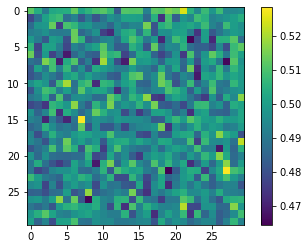

In [68]:
x = tf.random.normal([1,  256, 256, 3])
y = tf.random.uniform([1, 256, 256, 3])

disc_out = Discriminator()(x, y)
plt.imshow(disc_out[0, ..., 0])
plt.colorbar()

* 위 (30, 30) 크기를 갖는 결과 이미지의 각 픽셀값은 원래 입력의 (70, 70) 패치에 대한 분류 결과이다.
* 전체 입력의 크기가 (256, 256) 이므로, 각각의 (70, 70) 패치는 원래 입력상에서 많이 겹쳐있다.
* 각각의 픽셀값은 sigmoid 함수의 결괏값이므로 0 ~ 1 사이의 값을 가지며, 진짜 및 가짜 데이터를 판별해내는 데 사용한다.
* 드디어 Pix2Pix를 구성하는 Generator와 Discriminator의 구현이 끝났다.
* 다음은 본격적인 모델 학습을 진행해본다.

### 5. 학습 및 테스트하기

* 이번 단계에서는 구현된 Generator와 Discriminator를 학습시켜보고, 스케치를 입력으로 채색된 이미지를 생성해본다.
* 먼저 학습에 필요한 손실함수부터 정의한다.
* 레이블 정보만 있는 입력에 대해 여러 손실함수를 사용해 실제 이미지를 만들어 낸 결과는, 일반적인 GAN의 손실함수에 L1을 추가로 이용했을 때 가장 실제에 가까운 이미지를 생성한다고 한다.
* 이번 실험에서도 두 가지 손실 함수를 모두 사용해본다.

In [69]:
bce = losses.BinaryCrossentropy(from_logits = False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss   = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

* Generator 및 Discriminator의 손실 계산을 각각 정의했다.
* Generator의 손실함수 (위 코드의 get_gene_loss)는 총 3개의 입력이 있다. 이 중 fake_disc는 Generator가 생성한 가짜 이미지를 Discriminator에 입력하여 얻어진 값이며, 실제 이미지를 뜻하는 "1"과 비교하기 위해 tf.ones_like()를 사용합니다. 또한 L1 손실을 계산하기 위해 생성한 가짜 이미지(fake_output)와 실제 이미지(real_output) 사이의 MAE(Mean Absolute Error)를 계산한다.
* Discriminator의 손실함수 (위 코드의 get_disc_loss)는 2개의 입력이 있으며, 이들은 가짜 및 진짜 이미지가 Discriminator에 각각 입력되어 얻어진 값입니다. Discriminator는 실제 이미지를 잘 구분해 내야 하므로 real_disc는 "1"로 채워진 벡터와 비교하고, fake_disc는 "0"으로 채워진 벡터와 비교한다.
* 사용할 optimizer는 논문과 동일하게 설정했다.

In [70]:
gene_opt = optimizers.Adam(2e-4, beta_1 = 0.5, beta_2 = 0.999)
disc_opt = optimizers.Adam(2e-4, beta_1 = 0.5, beta_2 = 0.999)

* 하나의 배치 크기만큼 데이터를 입력했을 때 가중치를 1회 업데이트하는 과정은 아래와 같이 구현했다.

In [71]:
@tf.function
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_colored = generator(sketch, training = True)
        
        # Discriminator 예측
        fake_disc = discriminator(sketch, fake_colored, training = True)
        real_disc = discriminator(sketch, real_colored, training = True)
        
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss    = gene_loss + (100 * l1_loss) # L1 손실 반영 λ = 100
        
        # Discriminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
        
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

* 전반적인 학습 과정은 앞서 진행했었던 cGAN 학습과 크게 다르지 않다.
* 다만 위 코드의 gene_total_loss 계산 라인에서 최종 Generator 손실을 계산할 때, L1 손실에 100을 곱한 부분을 확인할 수 있다.
* λ는 학습 과정에서 L1 손실을 얼마나 반영할 것인지를 나타내며 논문에서는 λ = 100을 사용했다.
* 앞서 정의한 함수를 이용해서 학습을 진행한다.

In [72]:
EPOCHS = 150

generator     = UNetGenerator()
discriminator = Discriminator()

for epoch in range(1, EPOCHS + 1):
    for i, (sketch, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sketch, colored)
        
        # 10회 반복마다 손실을 출력한다.
        if (i + 1) % 10 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i + 1}] \
                  \nGenerator_loss : {g_loss.numpy():.4f} \
                  \nL1_loss : {l1_loss.numpy():.4f} \
                  \nDiscriminator_loss : {d_loss.numpy():.4f}", 
                  end = "\n\n")

EPOCH[1] - STEP[10]                   
Generator_loss : 0.8788                   
L1_loss : 0.3481                   
Discriminator_loss : 1.2843

EPOCH[1] - STEP[20]                   
Generator_loss : 1.1402                   
L1_loss : 0.2177                   
Discriminator_loss : 1.1479

EPOCH[1] - STEP[30]                   
Generator_loss : 0.8355                   
L1_loss : 0.2374                   
Discriminator_loss : 1.3073

EPOCH[1] - STEP[40]                   
Generator_loss : 0.7308                   
L1_loss : 0.1783                   
Discriminator_loss : 1.2804

EPOCH[1] - STEP[50]                   
Generator_loss : 0.8844                   
L1_loss : 0.1786                   
Discriminator_loss : 1.2168

EPOCH[1] - STEP[60]                   
Generator_loss : 0.9172                   
L1_loss : 0.1590                   
Discriminator_loss : 1.1808

EPOCH[1] - STEP[70]                   
Generator_loss : 0.9438                   
L1_loss : 0.1941                   


EPOCH[3] - STEP[70]                   
Generator_loss : 1.1874                   
L1_loss : 0.1841                   
Discriminator_loss : 1.6013

EPOCH[3] - STEP[80]                   
Generator_loss : 1.4156                   
L1_loss : 0.1768                   
Discriminator_loss : 0.6077

EPOCH[3] - STEP[90]                   
Generator_loss : 1.6895                   
L1_loss : 0.1321                   
Discriminator_loss : 1.4204

EPOCH[3] - STEP[100]                   
Generator_loss : 1.8763                   
L1_loss : 0.1647                   
Discriminator_loss : 0.4615

EPOCH[3] - STEP[110]                   
Generator_loss : 2.4302                   
L1_loss : 0.1829                   
Discriminator_loss : 0.3619

EPOCH[3] - STEP[120]                   
Generator_loss : 2.4058                   
L1_loss : 0.1730                   
Discriminator_loss : 1.8741

EPOCH[3] - STEP[130]                   
Generator_loss : 1.0888                   
L1_loss : 0.1717                

EPOCH[5] - STEP[130]                   
Generator_loss : 1.2546                   
L1_loss : 0.1584                   
Discriminator_loss : 0.7987

EPOCH[5] - STEP[140]                   
Generator_loss : 1.7302                   
L1_loss : 0.1817                   
Discriminator_loss : 1.6488

EPOCH[5] - STEP[150]                   
Generator_loss : 3.0038                   
L1_loss : 0.1895                   
Discriminator_loss : 0.2826

EPOCH[5] - STEP[160]                   
Generator_loss : 0.2998                   
L1_loss : 0.1690                   
Discriminator_loss : 1.7007

EPOCH[5] - STEP[170]                   
Generator_loss : 0.7612                   
L1_loss : 0.2226                   
Discriminator_loss : 0.8464

EPOCH[5] - STEP[180]                   
Generator_loss : 1.4152                   
L1_loss : 0.1401                   
Discriminator_loss : 1.2646

EPOCH[5] - STEP[190]                   
Generator_loss : 2.6388                   
L1_loss : 0.1633             

EPOCH[7] - STEP[190]                   
Generator_loss : 2.5404                   
L1_loss : 0.1787                   
Discriminator_loss : 1.1055

EPOCH[7] - STEP[200]                   
Generator_loss : 1.4102                   
L1_loss : 0.1564                   
Discriminator_loss : 1.6570

EPOCH[7] - STEP[210]                   
Generator_loss : 0.4586                   
L1_loss : 0.1751                   
Discriminator_loss : 1.2715

EPOCH[7] - STEP[220]                   
Generator_loss : 2.6592                   
L1_loss : 0.1823                   
Discriminator_loss : 1.4139

EPOCH[7] - STEP[230]                   
Generator_loss : 1.0577                   
L1_loss : 0.1522                   
Discriminator_loss : 0.7687

EPOCH[7] - STEP[240]                   
Generator_loss : 2.2651                   
L1_loss : 0.2133                   
Discriminator_loss : 0.1613

EPOCH[7] - STEP[250]                   
Generator_loss : 1.9096                   
L1_loss : 0.1491             

EPOCH[9] - STEP[250]                   
Generator_loss : 1.7560                   
L1_loss : 0.1669                   
Discriminator_loss : 0.5538

EPOCH[10] - STEP[10]                   
Generator_loss : 0.4212                   
L1_loss : 0.2197                   
Discriminator_loss : 1.1640

EPOCH[10] - STEP[20]                   
Generator_loss : 1.6579                   
L1_loss : 0.1763                   
Discriminator_loss : 0.3584

EPOCH[10] - STEP[30]                   
Generator_loss : 2.7679                   
L1_loss : 0.1823                   
Discriminator_loss : 0.4084

EPOCH[10] - STEP[40]                   
Generator_loss : 3.4680                   
L1_loss : 0.1695                   
Discriminator_loss : 0.5844

EPOCH[10] - STEP[50]                   
Generator_loss : 1.1159                   
L1_loss : 0.1628                   
Discriminator_loss : 0.8019

EPOCH[10] - STEP[60]                   
Generator_loss : 1.0855                   
L1_loss : 0.1564             

EPOCH[12] - STEP[60]                   
Generator_loss : 0.5731                   
L1_loss : 0.2029                   
Discriminator_loss : 0.9634

EPOCH[12] - STEP[70]                   
Generator_loss : 0.9587                   
L1_loss : 0.1971                   
Discriminator_loss : 0.7257

EPOCH[12] - STEP[80]                   
Generator_loss : 2.3226                   
L1_loss : 0.1692                   
Discriminator_loss : 0.7788

EPOCH[12] - STEP[90]                   
Generator_loss : 1.3479                   
L1_loss : 0.1743                   
Discriminator_loss : 0.8668

EPOCH[12] - STEP[100]                   
Generator_loss : 0.7408                   
L1_loss : 0.1607                   
Discriminator_loss : 1.0989

EPOCH[12] - STEP[110]                   
Generator_loss : 0.9794                   
L1_loss : 0.1808                   
Discriminator_loss : 0.9574

EPOCH[12] - STEP[120]                   
Generator_loss : 1.3957                   
L1_loss : 0.1676          

EPOCH[14] - STEP[120]                   
Generator_loss : 2.5750                   
L1_loss : 0.1704                   
Discriminator_loss : 1.1507

EPOCH[14] - STEP[130]                   
Generator_loss : 0.4086                   
L1_loss : 0.1959                   
Discriminator_loss : 1.5389

EPOCH[14] - STEP[140]                   
Generator_loss : 1.5596                   
L1_loss : 0.1683                   
Discriminator_loss : 0.5122

EPOCH[14] - STEP[150]                   
Generator_loss : 0.8287                   
L1_loss : 0.2547                   
Discriminator_loss : 0.6410

EPOCH[14] - STEP[160]                   
Generator_loss : 1.7089                   
L1_loss : 0.1619                   
Discriminator_loss : 2.1697

EPOCH[14] - STEP[170]                   
Generator_loss : 2.0886                   
L1_loss : 0.2059                   
Discriminator_loss : 0.1915

EPOCH[14] - STEP[180]                   
Generator_loss : 2.6037                   
L1_loss : 0.1720      

EPOCH[16] - STEP[180]                   
Generator_loss : 1.2821                   
L1_loss : 0.1937                   
Discriminator_loss : 0.8071

EPOCH[16] - STEP[190]                   
Generator_loss : 1.0365                   
L1_loss : 0.1714                   
Discriminator_loss : 0.5539

EPOCH[16] - STEP[200]                   
Generator_loss : 1.1401                   
L1_loss : 0.1959                   
Discriminator_loss : 0.4483

EPOCH[16] - STEP[210]                   
Generator_loss : 1.1018                   
L1_loss : 0.1524                   
Discriminator_loss : 0.8738

EPOCH[16] - STEP[220]                   
Generator_loss : 0.7526                   
L1_loss : 0.1820                   
Discriminator_loss : 1.2604

EPOCH[16] - STEP[230]                   
Generator_loss : 1.5175                   
L1_loss : 0.1816                   
Discriminator_loss : 0.5749

EPOCH[16] - STEP[240]                   
Generator_loss : 0.6478                   
L1_loss : 0.1630      

EPOCH[18] - STEP[240]                   
Generator_loss : 1.4549                   
L1_loss : 0.2193                   
Discriminator_loss : 0.6426

EPOCH[18] - STEP[250]                   
Generator_loss : 0.8497                   
L1_loss : 0.2012                   
Discriminator_loss : 0.9406

EPOCH[19] - STEP[10]                   
Generator_loss : 1.9097                   
L1_loss : 0.1541                   
Discriminator_loss : 1.9344

EPOCH[19] - STEP[20]                   
Generator_loss : 1.2026                   
L1_loss : 0.2144                   
Discriminator_loss : 0.4284

EPOCH[19] - STEP[30]                   
Generator_loss : 1.4862                   
L1_loss : 0.1704                   
Discriminator_loss : 1.2912

EPOCH[19] - STEP[40]                   
Generator_loss : 2.4230                   
L1_loss : 0.1653                   
Discriminator_loss : 2.5119

EPOCH[19] - STEP[50]                   
Generator_loss : 1.6394                   
L1_loss : 0.1848           

EPOCH[21] - STEP[50]                   
Generator_loss : 1.8483                   
L1_loss : 0.1676                   
Discriminator_loss : 0.8154

EPOCH[21] - STEP[60]                   
Generator_loss : 0.3126                   
L1_loss : 0.1951                   
Discriminator_loss : 1.5962

EPOCH[21] - STEP[70]                   
Generator_loss : 0.2193                   
L1_loss : 0.1672                   
Discriminator_loss : 2.0337

EPOCH[21] - STEP[80]                   
Generator_loss : 1.7162                   
L1_loss : 0.1790                   
Discriminator_loss : 0.3953

EPOCH[21] - STEP[90]                   
Generator_loss : 0.7668                   
L1_loss : 0.1995                   
Discriminator_loss : 0.7419

EPOCH[21] - STEP[100]                   
Generator_loss : 1.1957                   
L1_loss : 0.1965                   
Discriminator_loss : 0.7199

EPOCH[21] - STEP[110]                   
Generator_loss : 1.8521                   
L1_loss : 0.1724           

EPOCH[23] - STEP[110]                   
Generator_loss : 2.0602                   
L1_loss : 0.1820                   
Discriminator_loss : 0.2452

EPOCH[23] - STEP[120]                   
Generator_loss : 3.1808                   
L1_loss : 0.1717                   
Discriminator_loss : 1.4347

EPOCH[23] - STEP[130]                   
Generator_loss : 2.4957                   
L1_loss : 0.1592                   
Discriminator_loss : 1.0569

EPOCH[23] - STEP[140]                   
Generator_loss : 1.5423                   
L1_loss : 0.2044                   
Discriminator_loss : 0.2860

EPOCH[23] - STEP[150]                   
Generator_loss : 2.0868                   
L1_loss : 0.1810                   
Discriminator_loss : 0.4255

EPOCH[23] - STEP[160]                   
Generator_loss : 0.7614                   
L1_loss : 0.1812                   
Discriminator_loss : 0.8346

EPOCH[23] - STEP[170]                   
Generator_loss : 0.7829                   
L1_loss : 0.1394      

EPOCH[25] - STEP[170]                   
Generator_loss : 2.0347                   
L1_loss : 0.1670                   
Discriminator_loss : 0.3992

EPOCH[25] - STEP[180]                   
Generator_loss : 1.1206                   
L1_loss : 0.1974                   
Discriminator_loss : 0.4932

EPOCH[25] - STEP[190]                   
Generator_loss : 1.9731                   
L1_loss : 0.1784                   
Discriminator_loss : 0.3578

EPOCH[25] - STEP[200]                   
Generator_loss : 1.9491                   
L1_loss : 0.1779                   
Discriminator_loss : 0.5322

EPOCH[25] - STEP[210]                   
Generator_loss : 2.4704                   
L1_loss : 0.1994                   
Discriminator_loss : 0.1614

EPOCH[25] - STEP[220]                   
Generator_loss : 2.1136                   
L1_loss : 0.1754                   
Discriminator_loss : 1.0102

EPOCH[25] - STEP[230]                   
Generator_loss : 1.3014                   
L1_loss : 0.1477      

EPOCH[27] - STEP[230]                   
Generator_loss : 0.9700                   
L1_loss : 0.1802                   
Discriminator_loss : 0.9340

EPOCH[27] - STEP[240]                   
Generator_loss : 1.5888                   
L1_loss : 0.2083                   
Discriminator_loss : 1.2938

EPOCH[27] - STEP[250]                   
Generator_loss : 0.4070                   
L1_loss : 0.1726                   
Discriminator_loss : 1.8076

EPOCH[28] - STEP[10]                   
Generator_loss : 1.9110                   
L1_loss : 0.1703                   
Discriminator_loss : 1.9319

EPOCH[28] - STEP[20]                   
Generator_loss : 1.6774                   
L1_loss : 0.2201                   
Discriminator_loss : 0.2543

EPOCH[28] - STEP[30]                   
Generator_loss : 1.4160                   
L1_loss : 0.1856                   
Discriminator_loss : 0.8916

EPOCH[28] - STEP[40]                   
Generator_loss : 2.0432                   
L1_loss : 0.1778          

EPOCH[30] - STEP[40]                   
Generator_loss : 1.9346                   
L1_loss : 0.1599                   
Discriminator_loss : 0.6857

EPOCH[30] - STEP[50]                   
Generator_loss : 1.4736                   
L1_loss : 0.1483                   
Discriminator_loss : 0.9908

EPOCH[30] - STEP[60]                   
Generator_loss : 0.6355                   
L1_loss : 0.1702                   
Discriminator_loss : 1.0178

EPOCH[30] - STEP[70]                   
Generator_loss : 1.4644                   
L1_loss : 0.1785                   
Discriminator_loss : 0.9294

EPOCH[30] - STEP[80]                   
Generator_loss : 2.4952                   
L1_loss : 0.1810                   
Discriminator_loss : 0.2061

EPOCH[30] - STEP[90]                   
Generator_loss : 1.4580                   
L1_loss : 0.1677                   
Discriminator_loss : 1.2467

EPOCH[30] - STEP[100]                   
Generator_loss : 2.0094                   
L1_loss : 0.1566            

EPOCH[32] - STEP[100]                   
Generator_loss : 0.8939                   
L1_loss : 0.1528                   
Discriminator_loss : 1.3393

EPOCH[32] - STEP[110]                   
Generator_loss : 2.0250                   
L1_loss : 0.1969                   
Discriminator_loss : 0.2786

EPOCH[32] - STEP[120]                   
Generator_loss : 0.3554                   
L1_loss : 0.1800                   
Discriminator_loss : 1.6633

EPOCH[32] - STEP[130]                   
Generator_loss : 1.4209                   
L1_loss : 0.1465                   
Discriminator_loss : 0.8452

EPOCH[32] - STEP[140]                   
Generator_loss : 1.8440                   
L1_loss : 0.1648                   
Discriminator_loss : 0.7273

EPOCH[32] - STEP[150]                   
Generator_loss : 0.3496                   
L1_loss : 0.1905                   
Discriminator_loss : 1.4307

EPOCH[32] - STEP[160]                   
Generator_loss : 1.8048                   
L1_loss : 0.1939      

EPOCH[34] - STEP[160]                   
Generator_loss : 0.3387                   
L1_loss : 0.1791                   
Discriminator_loss : 1.4653

EPOCH[34] - STEP[170]                   
Generator_loss : 0.5011                   
L1_loss : 0.1734                   
Discriminator_loss : 1.1426

EPOCH[34] - STEP[180]                   
Generator_loss : 2.6590                   
L1_loss : 0.1714                   
Discriminator_loss : 0.9755

EPOCH[34] - STEP[190]                   
Generator_loss : 1.2277                   
L1_loss : 0.1778                   
Discriminator_loss : 0.8814

EPOCH[34] - STEP[200]                   
Generator_loss : 2.0409                   
L1_loss : 0.1969                   
Discriminator_loss : 0.7498

EPOCH[34] - STEP[210]                   
Generator_loss : 1.6730                   
L1_loss : 0.1581                   
Discriminator_loss : 0.6384

EPOCH[34] - STEP[220]                   
Generator_loss : 1.0378                   
L1_loss : 0.1558      

EPOCH[36] - STEP[220]                   
Generator_loss : 1.8628                   
L1_loss : 0.1595                   
Discriminator_loss : 0.3052

EPOCH[36] - STEP[230]                   
Generator_loss : 1.6466                   
L1_loss : 0.1691                   
Discriminator_loss : 0.4190

EPOCH[36] - STEP[240]                   
Generator_loss : 1.1577                   
L1_loss : 0.1583                   
Discriminator_loss : 0.8343

EPOCH[36] - STEP[250]                   
Generator_loss : 1.7468                   
L1_loss : 0.1781                   
Discriminator_loss : 0.3197

EPOCH[37] - STEP[10]                   
Generator_loss : 0.6041                   
L1_loss : 0.1669                   
Discriminator_loss : 1.1006

EPOCH[37] - STEP[20]                   
Generator_loss : 1.1650                   
L1_loss : 0.1801                   
Discriminator_loss : 0.5287

EPOCH[37] - STEP[30]                   
Generator_loss : 0.8234                   
L1_loss : 0.1957         

EPOCH[39] - STEP[30]                   
Generator_loss : 2.0434                   
L1_loss : 0.1454                   
Discriminator_loss : 2.0344

EPOCH[39] - STEP[40]                   
Generator_loss : 1.5520                   
L1_loss : 0.1473                   
Discriminator_loss : 1.2615

EPOCH[39] - STEP[50]                   
Generator_loss : 2.4348                   
L1_loss : 0.2076                   
Discriminator_loss : 0.3337

EPOCH[39] - STEP[60]                   
Generator_loss : 2.7280                   
L1_loss : 0.1851                   
Discriminator_loss : 1.5799

EPOCH[39] - STEP[70]                   
Generator_loss : 1.0005                   
L1_loss : 0.1567                   
Discriminator_loss : 0.6285

EPOCH[39] - STEP[80]                   
Generator_loss : 1.4773                   
L1_loss : 0.1664                   
Discriminator_loss : 0.7175

EPOCH[39] - STEP[90]                   
Generator_loss : 1.6104                   
L1_loss : 0.1786             

EPOCH[41] - STEP[90]                   
Generator_loss : 3.3579                   
L1_loss : 0.1849                   
Discriminator_loss : 0.4460

EPOCH[41] - STEP[100]                   
Generator_loss : 2.0711                   
L1_loss : 0.1597                   
Discriminator_loss : 0.7285

EPOCH[41] - STEP[110]                   
Generator_loss : 1.2320                   
L1_loss : 0.1313                   
Discriminator_loss : 1.1377

EPOCH[41] - STEP[120]                   
Generator_loss : 0.5507                   
L1_loss : 0.2141                   
Discriminator_loss : 1.1275

EPOCH[41] - STEP[130]                   
Generator_loss : 1.0846                   
L1_loss : 0.1569                   
Discriminator_loss : 1.2029

EPOCH[41] - STEP[140]                   
Generator_loss : 1.7251                   
L1_loss : 0.1614                   
Discriminator_loss : 0.4833

EPOCH[41] - STEP[150]                   
Generator_loss : 0.7831                   
L1_loss : 0.1943       

EPOCH[43] - STEP[150]                   
Generator_loss : 0.5408                   
L1_loss : 0.1791                   
Discriminator_loss : 1.0226

EPOCH[43] - STEP[160]                   
Generator_loss : 1.5715                   
L1_loss : 0.1784                   
Discriminator_loss : 0.6970

EPOCH[43] - STEP[170]                   
Generator_loss : 1.8576                   
L1_loss : 0.1618                   
Discriminator_loss : 1.3460

EPOCH[43] - STEP[180]                   
Generator_loss : 2.4033                   
L1_loss : 0.1851                   
Discriminator_loss : 0.1695

EPOCH[43] - STEP[190]                   
Generator_loss : 2.5986                   
L1_loss : 0.1771                   
Discriminator_loss : 1.3357

EPOCH[43] - STEP[200]                   
Generator_loss : 1.8917                   
L1_loss : 0.1654                   
Discriminator_loss : 0.5574

EPOCH[43] - STEP[210]                   
Generator_loss : 0.9209                   
L1_loss : 0.1696      

EPOCH[45] - STEP[210]                   
Generator_loss : 1.6792                   
L1_loss : 0.1621                   
Discriminator_loss : 0.5581

EPOCH[45] - STEP[220]                   
Generator_loss : 1.4084                   
L1_loss : 0.2302                   
Discriminator_loss : 0.4512

EPOCH[45] - STEP[230]                   
Generator_loss : 2.1926                   
L1_loss : 0.2029                   
Discriminator_loss : 0.4678

EPOCH[45] - STEP[240]                   
Generator_loss : 0.6267                   
L1_loss : 0.1821                   
Discriminator_loss : 0.9765

EPOCH[45] - STEP[250]                   
Generator_loss : 1.7751                   
L1_loss : 0.1831                   
Discriminator_loss : 0.5101

EPOCH[46] - STEP[10]                   
Generator_loss : 1.5372                   
L1_loss : 0.1804                   
Discriminator_loss : 1.6423

EPOCH[46] - STEP[20]                   
Generator_loss : 1.1709                   
L1_loss : 0.1596        

EPOCH[48] - STEP[20]                   
Generator_loss : 0.7455                   
L1_loss : 0.1774                   
Discriminator_loss : 0.8632

EPOCH[48] - STEP[30]                   
Generator_loss : 1.7559                   
L1_loss : 0.1722                   
Discriminator_loss : 0.3879

EPOCH[48] - STEP[40]                   
Generator_loss : 0.9870                   
L1_loss : 0.1692                   
Discriminator_loss : 1.0526

EPOCH[48] - STEP[50]                   
Generator_loss : 0.2642                   
L1_loss : 0.1542                   
Discriminator_loss : 1.6680

EPOCH[48] - STEP[60]                   
Generator_loss : 1.7218                   
L1_loss : 0.1571                   
Discriminator_loss : 1.0411

EPOCH[48] - STEP[70]                   
Generator_loss : 0.7711                   
L1_loss : 0.1846                   
Discriminator_loss : 0.7635

EPOCH[48] - STEP[80]                   
Generator_loss : 1.2216                   
L1_loss : 0.1565             

EPOCH[50] - STEP[80]                   
Generator_loss : 0.7771                   
L1_loss : 0.1911                   
Discriminator_loss : 0.8107

EPOCH[50] - STEP[90]                   
Generator_loss : 1.9353                   
L1_loss : 0.1865                   
Discriminator_loss : 0.3889

EPOCH[50] - STEP[100]                   
Generator_loss : 1.6466                   
L1_loss : 0.1860                   
Discriminator_loss : 0.8883

EPOCH[50] - STEP[110]                   
Generator_loss : 1.4272                   
L1_loss : 0.1477                   
Discriminator_loss : 0.9371

EPOCH[50] - STEP[120]                   
Generator_loss : 2.0042                   
L1_loss : 0.1515                   
Discriminator_loss : 0.2794

EPOCH[50] - STEP[130]                   
Generator_loss : 2.0817                   
L1_loss : 0.1555                   
Discriminator_loss : 1.2606

EPOCH[50] - STEP[140]                   
Generator_loss : 0.8671                   
L1_loss : 0.1660        

EPOCH[52] - STEP[140]                   
Generator_loss : 1.5693                   
L1_loss : 0.1905                   
Discriminator_loss : 0.3805

EPOCH[52] - STEP[150]                   
Generator_loss : 1.6409                   
L1_loss : 0.1670                   
Discriminator_loss : 0.6508

EPOCH[52] - STEP[160]                   
Generator_loss : 1.3800                   
L1_loss : 0.2210                   
Discriminator_loss : 0.3674

EPOCH[52] - STEP[170]                   
Generator_loss : 2.5124                   
L1_loss : 0.1898                   
Discriminator_loss : 0.3531

EPOCH[52] - STEP[180]                   
Generator_loss : 1.6633                   
L1_loss : 0.1719                   
Discriminator_loss : 1.1074

EPOCH[52] - STEP[190]                   
Generator_loss : 1.5005                   
L1_loss : 0.1657                   
Discriminator_loss : 0.8562

EPOCH[52] - STEP[200]                   
Generator_loss : 2.2295                   
L1_loss : 0.1801      

EPOCH[54] - STEP[200]                   
Generator_loss : 0.4658                   
L1_loss : 0.1777                   
Discriminator_loss : 1.6641

EPOCH[54] - STEP[210]                   
Generator_loss : 0.7691                   
L1_loss : 0.2174                   
Discriminator_loss : 0.7350

EPOCH[54] - STEP[220]                   
Generator_loss : 1.1966                   
L1_loss : 0.1480                   
Discriminator_loss : 0.9436

EPOCH[54] - STEP[230]                   
Generator_loss : 1.4714                   
L1_loss : 0.1667                   
Discriminator_loss : 1.1271

EPOCH[54] - STEP[240]                   
Generator_loss : 3.1149                   
L1_loss : 0.1715                   
Discriminator_loss : 2.1861

EPOCH[54] - STEP[250]                   
Generator_loss : 0.9374                   
L1_loss : 0.1443                   
Discriminator_loss : 1.0448

EPOCH[55] - STEP[10]                   
Generator_loss : 1.7187                   
L1_loss : 0.1519       

EPOCH[57] - STEP[10]                   
Generator_loss : 1.2329                   
L1_loss : 0.2037                   
Discriminator_loss : 0.4172

EPOCH[57] - STEP[20]                   
Generator_loss : 1.7379                   
L1_loss : 0.1792                   
Discriminator_loss : 0.3446

EPOCH[57] - STEP[30]                   
Generator_loss : 1.0544                   
L1_loss : 0.1448                   
Discriminator_loss : 1.8472

EPOCH[57] - STEP[40]                   
Generator_loss : 1.2027                   
L1_loss : 0.1599                   
Discriminator_loss : 1.3691

EPOCH[57] - STEP[50]                   
Generator_loss : 1.4339                   
L1_loss : 0.1700                   
Discriminator_loss : 0.5246

EPOCH[57] - STEP[60]                   
Generator_loss : 1.6007                   
L1_loss : 0.1771                   
Discriminator_loss : 0.3525

EPOCH[57] - STEP[70]                   
Generator_loss : 1.0362                   
L1_loss : 0.1366             

EPOCH[59] - STEP[70]                   
Generator_loss : 1.6290                   
L1_loss : 0.1622                   
Discriminator_loss : 0.4818

EPOCH[59] - STEP[80]                   
Generator_loss : 1.2852                   
L1_loss : 0.1592                   
Discriminator_loss : 0.5337

EPOCH[59] - STEP[90]                   
Generator_loss : 1.7271                   
L1_loss : 0.1760                   
Discriminator_loss : 1.4040

EPOCH[59] - STEP[100]                   
Generator_loss : 1.3478                   
L1_loss : 0.1867                   
Discriminator_loss : 1.4310

EPOCH[59] - STEP[110]                   
Generator_loss : 0.7618                   
L1_loss : 0.1632                   
Discriminator_loss : 0.8613

EPOCH[59] - STEP[120]                   
Generator_loss : 1.2062                   
L1_loss : 0.1912                   
Discriminator_loss : 0.5504

EPOCH[59] - STEP[130]                   
Generator_loss : 0.9853                   
L1_loss : 0.1485         

EPOCH[61] - STEP[130]                   
Generator_loss : 1.1480                   
L1_loss : 0.1755                   
Discriminator_loss : 0.8244

EPOCH[61] - STEP[140]                   
Generator_loss : 0.3756                   
L1_loss : 0.2038                   
Discriminator_loss : 1.4776

EPOCH[61] - STEP[150]                   
Generator_loss : 0.7745                   
L1_loss : 0.1780                   
Discriminator_loss : 0.7969

EPOCH[61] - STEP[160]                   
Generator_loss : 1.8325                   
L1_loss : 0.1845                   
Discriminator_loss : 1.2642

EPOCH[61] - STEP[170]                   
Generator_loss : 1.2449                   
L1_loss : 0.1657                   
Discriminator_loss : 1.0079

EPOCH[61] - STEP[180]                   
Generator_loss : 1.5280                   
L1_loss : 0.2084                   
Discriminator_loss : 0.3485

EPOCH[61] - STEP[190]                   
Generator_loss : 1.5930                   
L1_loss : 0.1559      

EPOCH[63] - STEP[190]                   
Generator_loss : 1.3126                   
L1_loss : 0.1688                   
Discriminator_loss : 0.9131

EPOCH[63] - STEP[200]                   
Generator_loss : 3.0895                   
L1_loss : 0.1878                   
Discriminator_loss : 0.1433

EPOCH[63] - STEP[210]                   
Generator_loss : 2.3438                   
L1_loss : 0.1604                   
Discriminator_loss : 2.5206

EPOCH[63] - STEP[220]                   
Generator_loss : 2.1446                   
L1_loss : 0.2010                   
Discriminator_loss : 0.4082

EPOCH[63] - STEP[230]                   
Generator_loss : 1.5805                   
L1_loss : 0.1833                   
Discriminator_loss : 0.5262

EPOCH[63] - STEP[240]                   
Generator_loss : 1.8417                   
L1_loss : 0.1686                   
Discriminator_loss : 0.6248

EPOCH[63] - STEP[250]                   
Generator_loss : 2.1902                   
L1_loss : 0.1694      

EPOCH[65] - STEP[250]                   
Generator_loss : 0.6812                   
L1_loss : 0.1617                   
Discriminator_loss : 1.0280

EPOCH[66] - STEP[10]                   
Generator_loss : 1.0949                   
L1_loss : 0.1822                   
Discriminator_loss : 0.6181

EPOCH[66] - STEP[20]                   
Generator_loss : 1.8962                   
L1_loss : 0.1708                   
Discriminator_loss : 0.3900

EPOCH[66] - STEP[30]                   
Generator_loss : 1.9686                   
L1_loss : 0.1420                   
Discriminator_loss : 1.0217

EPOCH[66] - STEP[40]                   
Generator_loss : 0.7621                   
L1_loss : 0.1716                   
Discriminator_loss : 1.0063

EPOCH[66] - STEP[50]                   
Generator_loss : 0.6008                   
L1_loss : 0.1848                   
Discriminator_loss : 0.9693

EPOCH[66] - STEP[60]                   
Generator_loss : 1.8997                   
L1_loss : 0.1927            

EPOCH[68] - STEP[60]                   
Generator_loss : 1.6113                   
L1_loss : 0.1644                   
Discriminator_loss : 0.4222

EPOCH[68] - STEP[70]                   
Generator_loss : 0.3993                   
L1_loss : 0.1612                   
Discriminator_loss : 1.3822

EPOCH[68] - STEP[80]                   
Generator_loss : 0.7540                   
L1_loss : 0.1611                   
Discriminator_loss : 1.0076

EPOCH[68] - STEP[90]                   
Generator_loss : 1.1819                   
L1_loss : 0.1811                   
Discriminator_loss : 0.5067

EPOCH[68] - STEP[100]                   
Generator_loss : 2.2038                   
L1_loss : 0.2051                   
Discriminator_loss : 0.1912

EPOCH[68] - STEP[110]                   
Generator_loss : 1.6903                   
L1_loss : 0.1504                   
Discriminator_loss : 1.7893

EPOCH[68] - STEP[120]                   
Generator_loss : 1.5835                   
L1_loss : 0.1798          

EPOCH[70] - STEP[120]                   
Generator_loss : 1.1852                   
L1_loss : 0.1838                   
Discriminator_loss : 0.4856

EPOCH[70] - STEP[130]                   
Generator_loss : 1.2636                   
L1_loss : 0.1614                   
Discriminator_loss : 0.6388

EPOCH[70] - STEP[140]                   
Generator_loss : 2.9145                   
L1_loss : 0.1931                   
Discriminator_loss : 1.8174

EPOCH[70] - STEP[150]                   
Generator_loss : 1.8866                   
L1_loss : 0.1753                   
Discriminator_loss : 1.1628

EPOCH[70] - STEP[160]                   
Generator_loss : 2.0362                   
L1_loss : 0.1720                   
Discriminator_loss : 0.7409

EPOCH[70] - STEP[170]                   
Generator_loss : 1.3899                   
L1_loss : 0.1802                   
Discriminator_loss : 0.5117

EPOCH[70] - STEP[180]                   
Generator_loss : 1.2923                   
L1_loss : 0.1587      

EPOCH[72] - STEP[180]                   
Generator_loss : 1.3184                   
L1_loss : 0.1940                   
Discriminator_loss : 0.4121

EPOCH[72] - STEP[190]                   
Generator_loss : 2.4786                   
L1_loss : 0.2214                   
Discriminator_loss : 0.1492

EPOCH[72] - STEP[200]                   
Generator_loss : 1.1581                   
L1_loss : 0.1614                   
Discriminator_loss : 0.9202

EPOCH[72] - STEP[210]                   
Generator_loss : 0.8781                   
L1_loss : 0.1947                   
Discriminator_loss : 0.6224

EPOCH[72] - STEP[220]                   
Generator_loss : 1.6231                   
L1_loss : 0.1648                   
Discriminator_loss : 0.6208

EPOCH[72] - STEP[230]                   
Generator_loss : 1.6870                   
L1_loss : 0.1758                   
Discriminator_loss : 0.2993

EPOCH[72] - STEP[240]                   
Generator_loss : 0.8929                   
L1_loss : 0.1759      

EPOCH[74] - STEP[240]                   
Generator_loss : 2.8352                   
L1_loss : 0.2104                   
Discriminator_loss : 0.0866

EPOCH[74] - STEP[250]                   
Generator_loss : 1.3416                   
L1_loss : 0.1964                   
Discriminator_loss : 0.4580

EPOCH[75] - STEP[10]                   
Generator_loss : 1.4153                   
L1_loss : 0.2082                   
Discriminator_loss : 0.4988

EPOCH[75] - STEP[20]                   
Generator_loss : 0.9362                   
L1_loss : 0.1742                   
Discriminator_loss : 0.8644

EPOCH[75] - STEP[30]                   
Generator_loss : 0.4467                   
L1_loss : 0.1441                   
Discriminator_loss : 2.0616

EPOCH[75] - STEP[40]                   
Generator_loss : 1.3715                   
L1_loss : 0.1537                   
Discriminator_loss : 0.8011

EPOCH[75] - STEP[50]                   
Generator_loss : 2.4696                   
L1_loss : 0.1682           

EPOCH[77] - STEP[50]                   
Generator_loss : 1.3036                   
L1_loss : 0.2006                   
Discriminator_loss : 0.3778

EPOCH[77] - STEP[60]                   
Generator_loss : 2.4041                   
L1_loss : 0.1688                   
Discriminator_loss : 1.6763

EPOCH[77] - STEP[70]                   
Generator_loss : 1.7704                   
L1_loss : 0.1670                   
Discriminator_loss : 1.2157

EPOCH[77] - STEP[80]                   
Generator_loss : 0.6178                   
L1_loss : 0.1883                   
Discriminator_loss : 0.9248

EPOCH[77] - STEP[90]                   
Generator_loss : 0.9919                   
L1_loss : 0.1646                   
Discriminator_loss : 0.6800

EPOCH[77] - STEP[100]                   
Generator_loss : 1.0609                   
L1_loss : 0.1560                   
Discriminator_loss : 2.6206

EPOCH[77] - STEP[110]                   
Generator_loss : 1.3054                   
L1_loss : 0.1514           

EPOCH[79] - STEP[110]                   
Generator_loss : 0.5922                   
L1_loss : 0.1809                   
Discriminator_loss : 0.9539

EPOCH[79] - STEP[120]                   
Generator_loss : 0.4905                   
L1_loss : 0.1522                   
Discriminator_loss : 1.4120

EPOCH[79] - STEP[130]                   
Generator_loss : 1.1622                   
L1_loss : 0.1858                   
Discriminator_loss : 1.1226

EPOCH[79] - STEP[140]                   
Generator_loss : 1.2937                   
L1_loss : 0.2363                   
Discriminator_loss : 0.3792

EPOCH[79] - STEP[150]                   
Generator_loss : 0.6277                   
L1_loss : 0.2150                   
Discriminator_loss : 0.9734

EPOCH[79] - STEP[160]                   
Generator_loss : 0.8008                   
L1_loss : 0.1612                   
Discriminator_loss : 0.7922

EPOCH[79] - STEP[170]                   
Generator_loss : 3.5689                   
L1_loss : 0.1622      

EPOCH[81] - STEP[170]                   
Generator_loss : 0.5419                   
L1_loss : 0.2078                   
Discriminator_loss : 1.2390

EPOCH[81] - STEP[180]                   
Generator_loss : 1.3554                   
L1_loss : 0.2049                   
Discriminator_loss : 0.3860

EPOCH[81] - STEP[190]                   
Generator_loss : 2.6621                   
L1_loss : 0.1637                   
Discriminator_loss : 2.4121

EPOCH[81] - STEP[200]                   
Generator_loss : 0.7459                   
L1_loss : 0.1555                   
Discriminator_loss : 1.3556

EPOCH[81] - STEP[210]                   
Generator_loss : 1.1546                   
L1_loss : 0.1727                   
Discriminator_loss : 0.8963

EPOCH[81] - STEP[220]                   
Generator_loss : 1.3129                   
L1_loss : 0.1801                   
Discriminator_loss : 1.1195

EPOCH[81] - STEP[230]                   
Generator_loss : 3.1760                   
L1_loss : 0.1517      

EPOCH[83] - STEP[230]                   
Generator_loss : 1.7660                   
L1_loss : 0.1826                   
Discriminator_loss : 0.7061

EPOCH[83] - STEP[240]                   
Generator_loss : 0.8116                   
L1_loss : 0.1648                   
Discriminator_loss : 1.2181

EPOCH[83] - STEP[250]                   
Generator_loss : 1.0726                   
L1_loss : 0.1538                   
Discriminator_loss : 0.6511

EPOCH[84] - STEP[10]                   
Generator_loss : 1.1139                   
L1_loss : 0.2141                   
Discriminator_loss : 0.5103

EPOCH[84] - STEP[20]                   
Generator_loss : 1.2369                   
L1_loss : 0.2077                   
Discriminator_loss : 0.4383

EPOCH[84] - STEP[30]                   
Generator_loss : 1.9692                   
L1_loss : 0.1731                   
Discriminator_loss : 0.2302

EPOCH[84] - STEP[40]                   
Generator_loss : 2.2227                   
L1_loss : 0.1654          

EPOCH[86] - STEP[40]                   
Generator_loss : 1.4224                   
L1_loss : 0.1708                   
Discriminator_loss : 0.6566

EPOCH[86] - STEP[50]                   
Generator_loss : 1.8349                   
L1_loss : 0.1847                   
Discriminator_loss : 0.8809

EPOCH[86] - STEP[60]                   
Generator_loss : 1.8202                   
L1_loss : 0.1726                   
Discriminator_loss : 1.1108

EPOCH[86] - STEP[70]                   
Generator_loss : 1.8255                   
L1_loss : 0.1414                   
Discriminator_loss : 1.7728

EPOCH[86] - STEP[80]                   
Generator_loss : 2.6404                   
L1_loss : 0.1918                   
Discriminator_loss : 0.2933

EPOCH[86] - STEP[90]                   
Generator_loss : 0.9497                   
L1_loss : 0.1575                   
Discriminator_loss : 1.1345

EPOCH[86] - STEP[100]                   
Generator_loss : 1.6351                   
L1_loss : 0.1863            

EPOCH[88] - STEP[100]                   
Generator_loss : 0.8400                   
L1_loss : 0.1576                   
Discriminator_loss : 0.9435

EPOCH[88] - STEP[110]                   
Generator_loss : 1.2769                   
L1_loss : 0.1755                   
Discriminator_loss : 0.8029

EPOCH[88] - STEP[120]                   
Generator_loss : 2.0559                   
L1_loss : 0.1760                   
Discriminator_loss : 1.0103

EPOCH[88] - STEP[130]                   
Generator_loss : 0.7270                   
L1_loss : 0.1595                   
Discriminator_loss : 1.9970

EPOCH[88] - STEP[140]                   
Generator_loss : 1.9732                   
L1_loss : 0.1743                   
Discriminator_loss : 0.3529

EPOCH[88] - STEP[150]                   
Generator_loss : 0.5394                   
L1_loss : 0.2042                   
Discriminator_loss : 1.3984

EPOCH[88] - STEP[160]                   
Generator_loss : 1.5870                   
L1_loss : 0.1846      

EPOCH[90] - STEP[160]                   
Generator_loss : 1.3383                   
L1_loss : 0.1867                   
Discriminator_loss : 1.4957

EPOCH[90] - STEP[170]                   
Generator_loss : 1.9431                   
L1_loss : 0.1593                   
Discriminator_loss : 1.2274

EPOCH[90] - STEP[180]                   
Generator_loss : 2.2875                   
L1_loss : 0.1844                   
Discriminator_loss : 0.4023

EPOCH[90] - STEP[190]                   
Generator_loss : 1.3066                   
L1_loss : 0.1781                   
Discriminator_loss : 0.7614

EPOCH[90] - STEP[200]                   
Generator_loss : 0.9820                   
L1_loss : 0.1770                   
Discriminator_loss : 0.9922

EPOCH[90] - STEP[210]                   
Generator_loss : 0.5211                   
L1_loss : 0.1833                   
Discriminator_loss : 1.3648

EPOCH[90] - STEP[220]                   
Generator_loss : 1.0065                   
L1_loss : 0.1657      

EPOCH[92] - STEP[220]                   
Generator_loss : 2.0157                   
L1_loss : 0.1508                   
Discriminator_loss : 1.7135

EPOCH[92] - STEP[230]                   
Generator_loss : 3.0016                   
L1_loss : 0.1816                   
Discriminator_loss : 0.4700

EPOCH[92] - STEP[240]                   
Generator_loss : 0.8066                   
L1_loss : 0.1556                   
Discriminator_loss : 0.8767

EPOCH[92] - STEP[250]                   
Generator_loss : 2.1394                   
L1_loss : 0.1890                   
Discriminator_loss : 0.2309

EPOCH[93] - STEP[10]                   
Generator_loss : 1.2885                   
L1_loss : 0.2107                   
Discriminator_loss : 0.3846

EPOCH[93] - STEP[20]                   
Generator_loss : 2.6475                   
L1_loss : 0.1646                   
Discriminator_loss : 0.6437

EPOCH[93] - STEP[30]                   
Generator_loss : 2.5515                   
L1_loss : 0.1626         

EPOCH[95] - STEP[30]                   
Generator_loss : 1.5931                   
L1_loss : 0.1521                   
Discriminator_loss : 1.4525

EPOCH[95] - STEP[40]                   
Generator_loss : 1.2221                   
L1_loss : 0.1549                   
Discriminator_loss : 0.7029

EPOCH[95] - STEP[50]                   
Generator_loss : 1.6907                   
L1_loss : 0.1544                   
Discriminator_loss : 1.1865

EPOCH[95] - STEP[60]                   
Generator_loss : 0.9986                   
L1_loss : 0.1661                   
Discriminator_loss : 0.6628

EPOCH[95] - STEP[70]                   
Generator_loss : 0.7423                   
L1_loss : 0.2207                   
Discriminator_loss : 1.4039

EPOCH[95] - STEP[80]                   
Generator_loss : 1.0944                   
L1_loss : 0.1865                   
Discriminator_loss : 0.7601

EPOCH[95] - STEP[90]                   
Generator_loss : 1.0927                   
L1_loss : 0.1905             

EPOCH[97] - STEP[90]                   
Generator_loss : 1.9256                   
L1_loss : 0.1566                   
Discriminator_loss : 1.4104

EPOCH[97] - STEP[100]                   
Generator_loss : 1.2033                   
L1_loss : 0.1824                   
Discriminator_loss : 0.4803

EPOCH[97] - STEP[110]                   
Generator_loss : 0.7165                   
L1_loss : 0.1569                   
Discriminator_loss : 1.7294

EPOCH[97] - STEP[120]                   
Generator_loss : 1.4010                   
L1_loss : 0.1833                   
Discriminator_loss : 0.5590

EPOCH[97] - STEP[130]                   
Generator_loss : 1.4861                   
L1_loss : 0.1904                   
Discriminator_loss : 0.4632

EPOCH[97] - STEP[140]                   
Generator_loss : 1.6156                   
L1_loss : 0.1551                   
Discriminator_loss : 1.3590

EPOCH[97] - STEP[150]                   
Generator_loss : 1.8637                   
L1_loss : 0.1810       

EPOCH[99] - STEP[150]                   
Generator_loss : 1.0274                   
L1_loss : 0.1908                   
Discriminator_loss : 1.2988

EPOCH[99] - STEP[160]                   
Generator_loss : 1.0516                   
L1_loss : 0.1379                   
Discriminator_loss : 0.8046

EPOCH[99] - STEP[170]                   
Generator_loss : 2.3406                   
L1_loss : 0.1521                   
Discriminator_loss : 0.5614

EPOCH[99] - STEP[180]                   
Generator_loss : 0.9820                   
L1_loss : 0.1643                   
Discriminator_loss : 0.7689

EPOCH[99] - STEP[190]                   
Generator_loss : 1.2941                   
L1_loss : 0.1771                   
Discriminator_loss : 0.8079

EPOCH[99] - STEP[200]                   
Generator_loss : 1.1479                   
L1_loss : 0.1750                   
Discriminator_loss : 0.5727

EPOCH[99] - STEP[210]                   
Generator_loss : 1.0514                   
L1_loss : 0.1805      

EPOCH[101] - STEP[200]                   
Generator_loss : 2.0219                   
L1_loss : 0.1460                   
Discriminator_loss : 1.8776

EPOCH[101] - STEP[210]                   
Generator_loss : 1.7961                   
L1_loss : 0.1715                   
Discriminator_loss : 0.7287

EPOCH[101] - STEP[220]                   
Generator_loss : 1.1892                   
L1_loss : 0.1592                   
Discriminator_loss : 1.1504

EPOCH[101] - STEP[230]                   
Generator_loss : 1.0202                   
L1_loss : 0.1745                   
Discriminator_loss : 0.8457

EPOCH[101] - STEP[240]                   
Generator_loss : 1.1271                   
L1_loss : 0.1934                   
Discriminator_loss : 0.5239

EPOCH[101] - STEP[250]                   
Generator_loss : 1.2046                   
L1_loss : 0.1396                   
Discriminator_loss : 1.0807

EPOCH[102] - STEP[10]                   
Generator_loss : 0.9884                   
L1_loss : 0.1866

EPOCH[103] - STEP[250]                   
Generator_loss : 0.9010                   
L1_loss : 0.2044                   
Discriminator_loss : 0.6579

EPOCH[104] - STEP[10]                   
Generator_loss : 1.6172                   
L1_loss : 0.1856                   
Discriminator_loss : 0.5538

EPOCH[104] - STEP[20]                   
Generator_loss : 1.8215                   
L1_loss : 0.1894                   
Discriminator_loss : 0.2659

EPOCH[104] - STEP[30]                   
Generator_loss : 0.9736                   
L1_loss : 0.1945                   
Discriminator_loss : 1.0099

EPOCH[104] - STEP[40]                   
Generator_loss : 1.7199                   
L1_loss : 0.1599                   
Discriminator_loss : 0.7928

EPOCH[104] - STEP[50]                   
Generator_loss : 0.6523                   
L1_loss : 0.1610                   
Discriminator_loss : 1.2341

EPOCH[104] - STEP[60]                   
Generator_loss : 2.1818                   
L1_loss : 0.1891     

EPOCH[106] - STEP[50]                   
Generator_loss : 1.2463                   
L1_loss : 0.2008                   
Discriminator_loss : 0.4488

EPOCH[106] - STEP[60]                   
Generator_loss : 1.6367                   
L1_loss : 0.1926                   
Discriminator_loss : 1.8481

EPOCH[106] - STEP[70]                   
Generator_loss : 1.2043                   
L1_loss : 0.1570                   
Discriminator_loss : 0.7714

EPOCH[106] - STEP[80]                   
Generator_loss : 1.8773                   
L1_loss : 0.2516                   
Discriminator_loss : 0.1948

EPOCH[106] - STEP[90]                   
Generator_loss : 2.2183                   
L1_loss : 0.1629                   
Discriminator_loss : 0.2937

EPOCH[106] - STEP[100]                   
Generator_loss : 0.5062                   
L1_loss : 0.1656                   
Discriminator_loss : 1.1824

EPOCH[106] - STEP[110]                   
Generator_loss : 0.8177                   
L1_loss : 0.1977    

EPOCH[108] - STEP[100]                   
Generator_loss : 0.9907                   
L1_loss : 0.1561                   
Discriminator_loss : 0.7895

EPOCH[108] - STEP[110]                   
Generator_loss : 0.9649                   
L1_loss : 0.2419                   
Discriminator_loss : 0.5770

EPOCH[108] - STEP[120]                   
Generator_loss : 1.5478                   
L1_loss : 0.1600                   
Discriminator_loss : 0.5149

EPOCH[108] - STEP[130]                   
Generator_loss : 1.3076                   
L1_loss : 0.1666                   
Discriminator_loss : 0.4514

EPOCH[108] - STEP[140]                   
Generator_loss : 1.6199                   
L1_loss : 0.1794                   
Discriminator_loss : 0.3843

EPOCH[108] - STEP[150]                   
Generator_loss : 0.3293                   
L1_loss : 0.1428                   
Discriminator_loss : 1.7591

EPOCH[108] - STEP[160]                   
Generator_loss : 0.9863                   
L1_loss : 0.196

EPOCH[110] - STEP[150]                   
Generator_loss : 0.3067                   
L1_loss : 0.2026                   
Discriminator_loss : 1.9496

EPOCH[110] - STEP[160]                   
Generator_loss : 1.4615                   
L1_loss : 0.1415                   
Discriminator_loss : 1.3535

EPOCH[110] - STEP[170]                   
Generator_loss : 0.4631                   
L1_loss : 0.1844                   
Discriminator_loss : 1.1160

EPOCH[110] - STEP[180]                   
Generator_loss : 0.7088                   
L1_loss : 0.1469                   
Discriminator_loss : 1.9811

EPOCH[110] - STEP[190]                   
Generator_loss : 1.7979                   
L1_loss : 0.1689                   
Discriminator_loss : 0.3531

EPOCH[110] - STEP[200]                   
Generator_loss : 1.1242                   
L1_loss : 0.1925                   
Discriminator_loss : 1.4439

EPOCH[110] - STEP[210]                   
Generator_loss : 1.5806                   
L1_loss : 0.182

EPOCH[112] - STEP[200]                   
Generator_loss : 2.3243                   
L1_loss : 0.1817                   
Discriminator_loss : 1.5209

EPOCH[112] - STEP[210]                   
Generator_loss : 1.5816                   
L1_loss : 0.1749                   
Discriminator_loss : 0.4585

EPOCH[112] - STEP[220]                   
Generator_loss : 1.8978                   
L1_loss : 0.1510                   
Discriminator_loss : 1.2141

EPOCH[112] - STEP[230]                   
Generator_loss : 2.1711                   
L1_loss : 0.1766                   
Discriminator_loss : 0.5267

EPOCH[112] - STEP[240]                   
Generator_loss : 0.6688                   
L1_loss : 0.1897                   
Discriminator_loss : 0.9417

EPOCH[112] - STEP[250]                   
Generator_loss : 1.1229                   
L1_loss : 0.1584                   
Discriminator_loss : 0.7212

EPOCH[113] - STEP[10]                   
Generator_loss : 2.0134                   
L1_loss : 0.1335

EPOCH[114] - STEP[250]                   
Generator_loss : 2.4758                   
L1_loss : 0.1989                   
Discriminator_loss : 0.8952

EPOCH[115] - STEP[10]                   
Generator_loss : 2.4160                   
L1_loss : 0.1588                   
Discriminator_loss : 1.4822

EPOCH[115] - STEP[20]                   
Generator_loss : 1.2709                   
L1_loss : 0.1869                   
Discriminator_loss : 0.5124

EPOCH[115] - STEP[30]                   
Generator_loss : 1.1803                   
L1_loss : 0.1700                   
Discriminator_loss : 0.6936

EPOCH[115] - STEP[40]                   
Generator_loss : 0.4966                   
L1_loss : 0.1828                   
Discriminator_loss : 1.1037

EPOCH[115] - STEP[50]                   
Generator_loss : 1.9329                   
L1_loss : 0.1630                   
Discriminator_loss : 1.7118

EPOCH[115] - STEP[60]                   
Generator_loss : 1.6162                   
L1_loss : 0.1699     

EPOCH[117] - STEP[50]                   
Generator_loss : 0.5923                   
L1_loss : 0.1523                   
Discriminator_loss : 1.2831

EPOCH[117] - STEP[60]                   
Generator_loss : 1.2844                   
L1_loss : 0.1496                   
Discriminator_loss : 0.6915

EPOCH[117] - STEP[70]                   
Generator_loss : 2.0483                   
L1_loss : 0.1546                   
Discriminator_loss : 1.1727

EPOCH[117] - STEP[80]                   
Generator_loss : 1.5719                   
L1_loss : 0.1819                   
Discriminator_loss : 0.5271

EPOCH[117] - STEP[90]                   
Generator_loss : 0.4128                   
L1_loss : 0.1345                   
Discriminator_loss : 1.8208

EPOCH[117] - STEP[100]                   
Generator_loss : 1.0050                   
L1_loss : 0.1655                   
Discriminator_loss : 0.6769

EPOCH[117] - STEP[110]                   
Generator_loss : 2.1770                   
L1_loss : 0.1398    

EPOCH[119] - STEP[100]                   
Generator_loss : 0.6640                   
L1_loss : 0.1549                   
Discriminator_loss : 1.5845

EPOCH[119] - STEP[110]                   
Generator_loss : 1.3507                   
L1_loss : 0.2241                   
Discriminator_loss : 0.6076

EPOCH[119] - STEP[120]                   
Generator_loss : 0.7799                   
L1_loss : 0.1718                   
Discriminator_loss : 0.7528

EPOCH[119] - STEP[130]                   
Generator_loss : 2.1722                   
L1_loss : 0.1713                   
Discriminator_loss : 0.4130

EPOCH[119] - STEP[140]                   
Generator_loss : 0.9082                   
L1_loss : 0.1729                   
Discriminator_loss : 1.9917

EPOCH[119] - STEP[150]                   
Generator_loss : 1.4468                   
L1_loss : 0.1494                   
Discriminator_loss : 0.8996

EPOCH[119] - STEP[160]                   
Generator_loss : 1.7350                   
L1_loss : 0.180

EPOCH[121] - STEP[150]                   
Generator_loss : 1.4890                   
L1_loss : 0.1995                   
Discriminator_loss : 0.3446

EPOCH[121] - STEP[160]                   
Generator_loss : 1.3777                   
L1_loss : 0.1487                   
Discriminator_loss : 1.1284

EPOCH[121] - STEP[170]                   
Generator_loss : 2.0743                   
L1_loss : 0.1773                   
Discriminator_loss : 0.1961

EPOCH[121] - STEP[180]                   
Generator_loss : 1.2068                   
L1_loss : 0.1656                   
Discriminator_loss : 0.6441

EPOCH[121] - STEP[190]                   
Generator_loss : 1.0432                   
L1_loss : 0.1589                   
Discriminator_loss : 0.8594

EPOCH[121] - STEP[200]                   
Generator_loss : 0.9304                   
L1_loss : 0.1839                   
Discriminator_loss : 0.6568

EPOCH[121] - STEP[210]                   
Generator_loss : 2.6888                   
L1_loss : 0.184

EPOCH[123] - STEP[200]                   
Generator_loss : 0.7489                   
L1_loss : 0.1807                   
Discriminator_loss : 1.1823

EPOCH[123] - STEP[210]                   
Generator_loss : 2.5667                   
L1_loss : 0.1900                   
Discriminator_loss : 1.4102

EPOCH[123] - STEP[220]                   
Generator_loss : 1.7598                   
L1_loss : 0.2087                   
Discriminator_loss : 0.2444

EPOCH[123] - STEP[230]                   
Generator_loss : 1.1806                   
L1_loss : 0.1567                   
Discriminator_loss : 1.0106

EPOCH[123] - STEP[240]                   
Generator_loss : 0.7965                   
L1_loss : 0.1599                   
Discriminator_loss : 0.7700

EPOCH[123] - STEP[250]                   
Generator_loss : 1.1141                   
L1_loss : 0.1806                   
Discriminator_loss : 0.5263

EPOCH[124] - STEP[10]                   
Generator_loss : 2.2968                   
L1_loss : 0.1739

EPOCH[125] - STEP[250]                   
Generator_loss : 2.7376                   
L1_loss : 0.1761                   
Discriminator_loss : 1.7045

EPOCH[126] - STEP[10]                   
Generator_loss : 0.5331                   
L1_loss : 0.1516                   
Discriminator_loss : 1.1449

EPOCH[126] - STEP[20]                   
Generator_loss : 0.4887                   
L1_loss : 0.1609                   
Discriminator_loss : 1.1735

EPOCH[126] - STEP[30]                   
Generator_loss : 1.1462                   
L1_loss : 0.1894                   
Discriminator_loss : 0.7052

EPOCH[126] - STEP[40]                   
Generator_loss : 3.1875                   
L1_loss : 0.1464                   
Discriminator_loss : 1.4357

EPOCH[126] - STEP[50]                   
Generator_loss : 1.3674                   
L1_loss : 0.1825                   
Discriminator_loss : 0.4687

EPOCH[126] - STEP[60]                   
Generator_loss : 1.8303                   
L1_loss : 0.1960     

EPOCH[128] - STEP[50]                   
Generator_loss : 1.3287                   
L1_loss : 0.1517                   
Discriminator_loss : 0.4193

EPOCH[128] - STEP[60]                   
Generator_loss : 2.1738                   
L1_loss : 0.1962                   
Discriminator_loss : 0.2880

EPOCH[128] - STEP[70]                   
Generator_loss : 0.6620                   
L1_loss : 0.1529                   
Discriminator_loss : 0.9530

EPOCH[128] - STEP[80]                   
Generator_loss : 1.4963                   
L1_loss : 0.1462                   
Discriminator_loss : 0.6968

EPOCH[128] - STEP[90]                   
Generator_loss : 1.6576                   
L1_loss : 0.1942                   
Discriminator_loss : 0.4362

EPOCH[128] - STEP[100]                   
Generator_loss : 2.0784                   
L1_loss : 0.1672                   
Discriminator_loss : 1.0547

EPOCH[128] - STEP[110]                   
Generator_loss : 1.3864                   
L1_loss : 0.1668    

EPOCH[130] - STEP[100]                   
Generator_loss : 1.1784                   
L1_loss : 0.1826                   
Discriminator_loss : 0.6984

EPOCH[130] - STEP[110]                   
Generator_loss : 1.1634                   
L1_loss : 0.1536                   
Discriminator_loss : 2.0454

EPOCH[130] - STEP[120]                   
Generator_loss : 0.8638                   
L1_loss : 0.1602                   
Discriminator_loss : 1.1997

EPOCH[130] - STEP[130]                   
Generator_loss : 1.8319                   
L1_loss : 0.1912                   
Discriminator_loss : 0.3148

EPOCH[130] - STEP[140]                   
Generator_loss : 2.0652                   
L1_loss : 0.1703                   
Discriminator_loss : 0.6934

EPOCH[130] - STEP[150]                   
Generator_loss : 1.7262                   
L1_loss : 0.1754                   
Discriminator_loss : 0.3594

EPOCH[130] - STEP[160]                   
Generator_loss : 1.5469                   
L1_loss : 0.169

EPOCH[132] - STEP[150]                   
Generator_loss : 0.2561                   
L1_loss : 0.1599                   
Discriminator_loss : 1.8106

EPOCH[132] - STEP[160]                   
Generator_loss : 0.5317                   
L1_loss : 0.1694                   
Discriminator_loss : 1.0389

EPOCH[132] - STEP[170]                   
Generator_loss : 1.0253                   
L1_loss : 0.1741                   
Discriminator_loss : 1.2101

EPOCH[132] - STEP[180]                   
Generator_loss : 1.6311                   
L1_loss : 0.1673                   
Discriminator_loss : 1.1370

EPOCH[132] - STEP[190]                   
Generator_loss : 0.7757                   
L1_loss : 0.1533                   
Discriminator_loss : 1.8007

EPOCH[132] - STEP[200]                   
Generator_loss : 1.7726                   
L1_loss : 0.1598                   
Discriminator_loss : 0.7781

EPOCH[132] - STEP[210]                   
Generator_loss : 0.8216                   
L1_loss : 0.181

EPOCH[134] - STEP[200]                   
Generator_loss : 2.0085                   
L1_loss : 0.1493                   
Discriminator_loss : 0.7802

EPOCH[134] - STEP[210]                   
Generator_loss : 1.1314                   
L1_loss : 0.1434                   
Discriminator_loss : 0.7976

EPOCH[134] - STEP[220]                   
Generator_loss : 1.2519                   
L1_loss : 0.1550                   
Discriminator_loss : 1.4926

EPOCH[134] - STEP[230]                   
Generator_loss : 1.2672                   
L1_loss : 0.1866                   
Discriminator_loss : 0.4858

EPOCH[134] - STEP[240]                   
Generator_loss : 1.2199                   
L1_loss : 0.2176                   
Discriminator_loss : 0.4140

EPOCH[134] - STEP[250]                   
Generator_loss : 1.0125                   
L1_loss : 0.1548                   
Discriminator_loss : 1.3055

EPOCH[135] - STEP[10]                   
Generator_loss : 1.2876                   
L1_loss : 0.1577

EPOCH[136] - STEP[250]                   
Generator_loss : 1.7223                   
L1_loss : 0.1505                   
Discriminator_loss : 0.2942

EPOCH[137] - STEP[10]                   
Generator_loss : 1.0351                   
L1_loss : 0.1930                   
Discriminator_loss : 0.5448

EPOCH[137] - STEP[20]                   
Generator_loss : 1.2228                   
L1_loss : 0.1526                   
Discriminator_loss : 1.9344

EPOCH[137] - STEP[30]                   
Generator_loss : 2.4047                   
L1_loss : 0.1605                   
Discriminator_loss : 1.5136

EPOCH[137] - STEP[40]                   
Generator_loss : 0.9185                   
L1_loss : 0.1742                   
Discriminator_loss : 1.5414

EPOCH[137] - STEP[50]                   
Generator_loss : 1.9237                   
L1_loss : 0.1457                   
Discriminator_loss : 2.0443

EPOCH[137] - STEP[60]                   
Generator_loss : 1.5412                   
L1_loss : 0.1744     

EPOCH[139] - STEP[50]                   
Generator_loss : 0.6018                   
L1_loss : 0.1677                   
Discriminator_loss : 1.1059

EPOCH[139] - STEP[60]                   
Generator_loss : 0.5606                   
L1_loss : 0.1624                   
Discriminator_loss : 1.2914

EPOCH[139] - STEP[70]                   
Generator_loss : 2.4246                   
L1_loss : 0.1543                   
Discriminator_loss : 2.1544

EPOCH[139] - STEP[80]                   
Generator_loss : 1.5446                   
L1_loss : 0.1514                   
Discriminator_loss : 1.7801

EPOCH[139] - STEP[90]                   
Generator_loss : 0.9293                   
L1_loss : 0.1519                   
Discriminator_loss : 0.6448

EPOCH[139] - STEP[100]                   
Generator_loss : 1.8016                   
L1_loss : 0.1577                   
Discriminator_loss : 1.3853

EPOCH[139] - STEP[110]                   
Generator_loss : 2.3173                   
L1_loss : 0.1586    

EPOCH[141] - STEP[100]                   
Generator_loss : 0.9229                   
L1_loss : 0.1444                   
Discriminator_loss : 1.0364

EPOCH[141] - STEP[110]                   
Generator_loss : 2.4302                   
L1_loss : 0.1834                   
Discriminator_loss : 0.4398

EPOCH[141] - STEP[120]                   
Generator_loss : 1.4834                   
L1_loss : 0.1756                   
Discriminator_loss : 0.7098

EPOCH[141] - STEP[130]                   
Generator_loss : 0.3657                   
L1_loss : 0.1594                   
Discriminator_loss : 1.6622

EPOCH[141] - STEP[140]                   
Generator_loss : 1.0852                   
L1_loss : 0.1631                   
Discriminator_loss : 0.7789

EPOCH[141] - STEP[150]                   
Generator_loss : 0.5792                   
L1_loss : 0.1532                   
Discriminator_loss : 1.1043

EPOCH[141] - STEP[160]                   
Generator_loss : 1.6112                   
L1_loss : 0.175

EPOCH[143] - STEP[150]                   
Generator_loss : 1.0101                   
L1_loss : 0.2031                   
Discriminator_loss : 0.6122

EPOCH[143] - STEP[160]                   
Generator_loss : 1.6347                   
L1_loss : 0.1834                   
Discriminator_loss : 0.6452

EPOCH[143] - STEP[170]                   
Generator_loss : 2.6188                   
L1_loss : 0.1664                   
Discriminator_loss : 1.7916

EPOCH[143] - STEP[180]                   
Generator_loss : 0.7147                   
L1_loss : 0.1734                   
Discriminator_loss : 0.9496

EPOCH[143] - STEP[190]                   
Generator_loss : 1.5248                   
L1_loss : 0.1906                   
Discriminator_loss : 0.3537

EPOCH[143] - STEP[200]                   
Generator_loss : 1.5214                   
L1_loss : 0.1775                   
Discriminator_loss : 0.4079

EPOCH[143] - STEP[210]                   
Generator_loss : 0.9013                   
L1_loss : 0.168

EPOCH[145] - STEP[200]                   
Generator_loss : 1.0200                   
L1_loss : 0.1606                   
Discriminator_loss : 0.6292

EPOCH[145] - STEP[210]                   
Generator_loss : 2.0879                   
L1_loss : 0.1843                   
Discriminator_loss : 0.2663

EPOCH[145] - STEP[220]                   
Generator_loss : 1.3028                   
L1_loss : 0.1965                   
Discriminator_loss : 0.4329

EPOCH[145] - STEP[230]                   
Generator_loss : 1.5792                   
L1_loss : 0.1654                   
Discriminator_loss : 1.0807

EPOCH[145] - STEP[240]                   
Generator_loss : 1.7076                   
L1_loss : 0.1806                   
Discriminator_loss : 0.9492

EPOCH[145] - STEP[250]                   
Generator_loss : 2.1079                   
L1_loss : 0.1620                   
Discriminator_loss : 1.3078

EPOCH[146] - STEP[10]                   
Generator_loss : 1.0620                   
L1_loss : 0.1629

EPOCH[147] - STEP[250]                   
Generator_loss : 0.9141                   
L1_loss : 0.1915                   
Discriminator_loss : 0.7721

EPOCH[148] - STEP[10]                   
Generator_loss : 2.1969                   
L1_loss : 0.1834                   
Discriminator_loss : 0.6358

EPOCH[148] - STEP[20]                   
Generator_loss : 0.6921                   
L1_loss : 0.1772                   
Discriminator_loss : 1.0617

EPOCH[148] - STEP[30]                   
Generator_loss : 1.2462                   
L1_loss : 0.1732                   
Discriminator_loss : 0.6461

EPOCH[148] - STEP[40]                   
Generator_loss : 1.8691                   
L1_loss : 0.2045                   
Discriminator_loss : 0.2248

EPOCH[148] - STEP[50]                   
Generator_loss : 2.2615                   
L1_loss : 0.2111                   
Discriminator_loss : 0.1468

EPOCH[148] - STEP[60]                   
Generator_loss : 0.8455                   
L1_loss : 0.1712     

EPOCH[150] - STEP[50]                   
Generator_loss : 2.0056                   
L1_loss : 0.1615                   
Discriminator_loss : 0.8652

EPOCH[150] - STEP[60]                   
Generator_loss : 0.6276                   
L1_loss : 0.1932                   
Discriminator_loss : 1.0774

EPOCH[150] - STEP[70]                   
Generator_loss : 0.6659                   
L1_loss : 0.1763                   
Discriminator_loss : 1.5018

EPOCH[150] - STEP[80]                   
Generator_loss : 1.0489                   
L1_loss : 0.1824                   
Discriminator_loss : 0.6385

EPOCH[150] - STEP[90]                   
Generator_loss : 1.1862                   
L1_loss : 0.1531                   
Discriminator_loss : 0.6389

EPOCH[150] - STEP[100]                   
Generator_loss : 1.5944                   
L1_loss : 0.2102                   
Discriminator_loss : 0.3114

EPOCH[150] - STEP[110]                   
Generator_loss : 1.3354                   
L1_loss : 0.1636    

* 아래 코드로 짧게나마 학습해 본 모델에 채색을 시켜보자. 아마 마음에 안 들 것이다.

In [73]:
val_path = os.getenv("HOME") + "/aiffel/conditional_generation/cityscapes/val/"
print("number of train examples :", len(os.listdir(val_path)))

number of train examples : 5


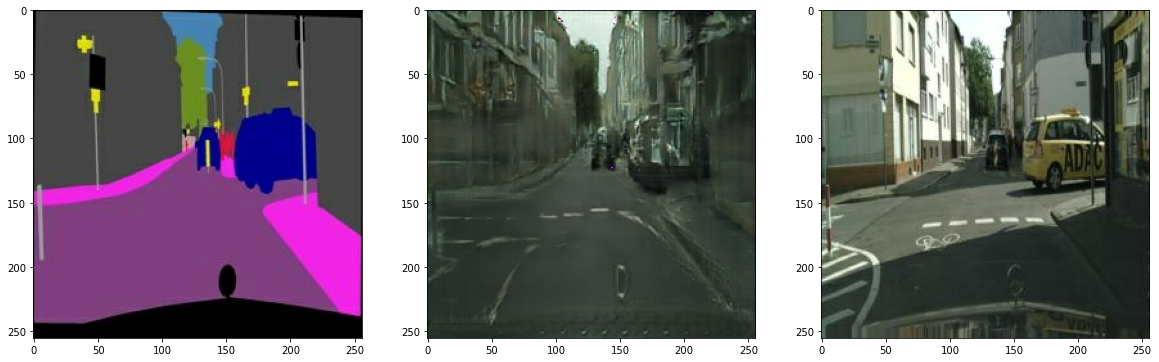

In [74]:
test_ind = 0

f = val_path + os.listdir(val_path)[test_ind]
sketch, colored = load_img(f)

pred = generator(tf.expand_dims(sketch, 0))
pred = denormalize(pred)

plt.figure(figsize = (20, 10))

plt.subplot(1, 3, 1)
plt.imshow(denormalize(sketch))

plt.subplot(1, 3, 2)
plt.imshow(pred[0])

plt.subplot(1, 3, 3)
plt.imshow(denormalize(colored))

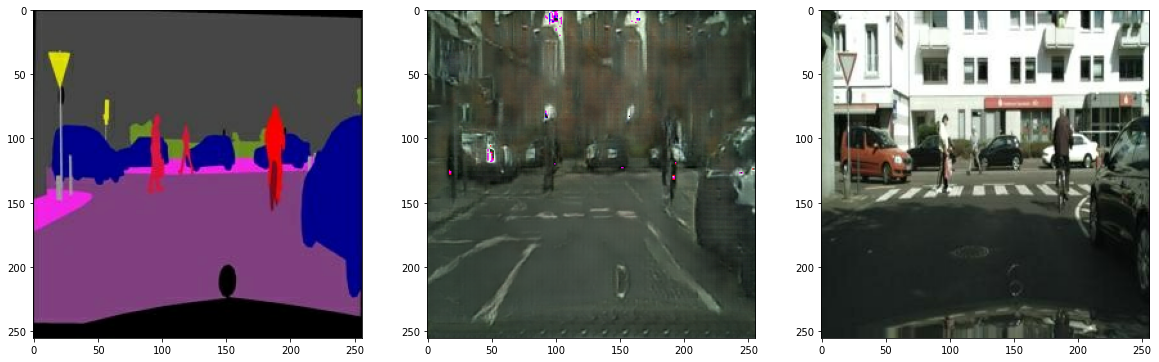

In [75]:
test_ind = 1

f = val_path + os.listdir(val_path)[test_ind]
sketch, colored = load_img(f)

pred = generator(tf.expand_dims(sketch, 0))
pred = denormalize(pred)

plt.figure(figsize = (20, 10))

plt.subplot(1, 3, 1)
plt.imshow(denormalize(sketch))

plt.subplot(1, 3, 2)
plt.imshow(pred[0])

plt.subplot(1, 3, 3)
plt.imshow(denormalize(colored))

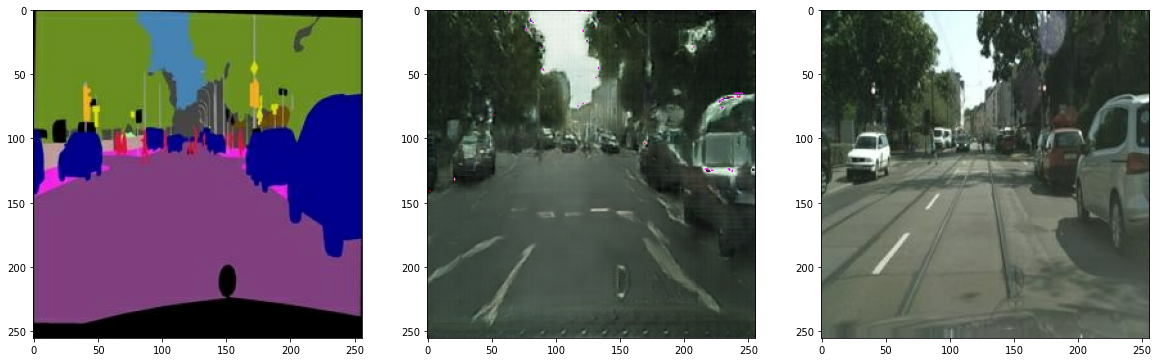

In [76]:
test_ind = 2

f = val_path + os.listdir(val_path)[test_ind]
sketch, colored = load_img(f)

pred = generator(tf.expand_dims(sketch, 0))
pred = denormalize(pred)

plt.figure(figsize = (20, 10))

plt.subplot(1, 3, 1)
plt.imshow(denormalize(sketch))

plt.subplot(1, 3, 2)
plt.imshow(pred[0])

plt.subplot(1, 3, 3)
plt.imshow(denormalize(colored))

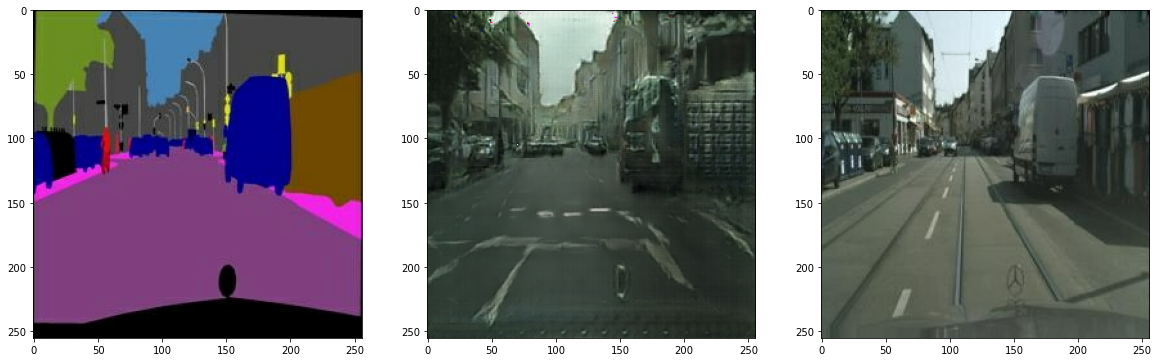

In [77]:
test_ind = 3

f = val_path + os.listdir(val_path)[test_ind]
sketch, colored = load_img(f)

pred = generator(tf.expand_dims(sketch, 0))
pred = denormalize(pred)

plt.figure(figsize = (20, 10))

plt.subplot(1, 3, 1)
plt.imshow(denormalize(sketch))

plt.subplot(1, 3, 2)
plt.imshow(pred[0])

plt.subplot(1, 3, 3)
plt.imshow(denormalize(colored))

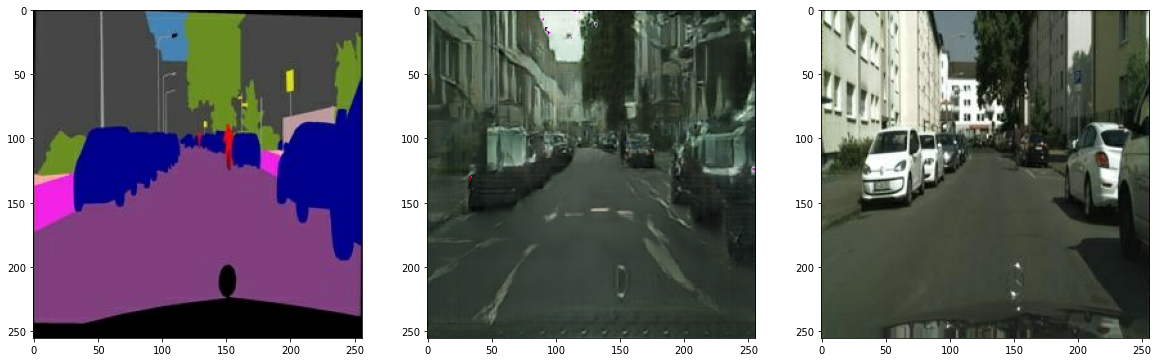

In [78]:
test_ind = 4

f = val_path + os.listdir(val_path)[test_ind]
sketch, colored = load_img(f)

pred = generator(tf.expand_dims(sketch, 0))
pred = denormalize(pred)

plt.figure(figsize = (20, 10))

plt.subplot(1, 3, 1)
plt.imshow(denormalize(sketch))

plt.subplot(1, 3, 2)
plt.imshow(pred[0])

plt.subplot(1, 3, 3)
plt.imshow(denormalize(colored))

## 회고록

In [ ]:
# 오늘은 GAN을 복습해보고 cGAN이란 모델을 배웠다.
# 처음에는 GAN을 사용하다가 그 다음은 cGAN을 사용하고, 데이터셋은 총 2개(MNIST, 포켓몬스케치)를 사용하여 서로의 차이점과 구현 방법을 배웠다.
# 그리고 프로젝트를 들어가니 포켓몬 스케치를 통해 채색한 것을 그대로 사용하는 듯 했다.
# 단지 포켓몬 데이터는 왼쪽이 스케치, 오른쪽이 채색이라하면 로드 사진은 왼쪽이 채색, 오른쪽이 영역이라 데이터를 분리할 때 코드를 다르게 했다.
# 나머지의 코드를 그대로 사용하니 얼추 돌아가고, valid 데이터도 5개만 있어서 학습한 가중치를 가지고 모델을 시험했다.
# 10 epoch 이상하라해서 150번을 했는데 얼추 도로와 자동차로 보이는 것은 만들었으나 아직 미흡한 것 같다.
# 앞서 500번 학습한 가중치들을 가지고 MNIST를 했던 것 처럼 500번 학습을 하면 어떻게 될지는 궁금하다.